## Импорты и загрузка данных

In [2]:
pip install langdetect

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import networkx as nx
from collections import Counter, defaultdict
import re
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
import warnings
import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from matplotlib.patches import Patch
warnings.filterwarnings('ignore')

# Для воспроизводимости результатов
DetectorFactory.seed = 42
np.random.seed(42)

# Настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

print("Библиотеки загружены")

Библиотеки загружены


In [4]:
# Загрузка данных
df = pd.read_csv('../data/raw/bom_dataset.csv')

# Первый взгляд на данные
print("\033[1;36m" + "ОСНОВНАЯ ИНФОРМАЦИЯ О ДАННЫХ" + "\033[0m")
print("=" * 60)
print(f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"\nНазвания столбцов: {list(df.columns)}")
print(f"\nТипы данных:\n{df.dtypes}")
print(f"\nПервые 5 строк:")
display(df.head())
print(f"\nПримеры уникальных значений в каждом столбце:")
for col in df.columns:
    unique_vals = df[col].nunique()
    sample_vals = df[col].dropna().unique()[:3] if unique_vals > 3 else df[col].dropna().unique()
    print(f"  {col}: {unique_vals} уникальных, примеры: {sample_vals}")

ОСНОВНАЯ ИНФОРМАЦИЯ О ДАННЫХ
Размер датасета: 649253 строк, 6 столбцов

Названия столбцов: ['qty', 'material_id', 'component_id', 'description', 'level', 'path']

Типы данных:
qty             float64
material_id      object
component_id     object
description      object
level             int64
path             object
dtype: object

Первые 5 строк:


,qty,material_id,component_id,description,level,path
0,1.0,00H6016,00H6016,Assembly 00H6016,0,00H6016
1,1.0,00H6016,210821600,BEARING HOUSING ASSY 19 EXH TRICO,0,00H6016.210821600
2,2.0,00H6016,401690203,DOWEL PIN HDND .375 X 1.25 STL,1,00H6016.210821600.401690203
3,4.0,00H6016,431513044,HHCS 5/8-11UNC-2A X 1.50 GR8,1,00H6016.210821600.431513044
4,1.0,00H6016,710821900,CAP BRG HOUSING EXH,1,00H6016.210821600.710821900



Примеры уникальных значений в каждом столбце:
  qty: 455 уникальных, примеры: [1. 2. 4.]
  material_id: 1884 уникальных, примеры: ['00H6016' '00H6071' '00H6154']
  component_id: 15751 уникальных, примеры: ['00H6016' '210821600' '401690203']
  description: 15106 уникальных, примеры: ['Assembly 00H6016' 'BEARING HOUSING ASSY 19 EXH TRICO'
 'DOWEL PIN HDND .375 X 1.25 STL']
  level: 10 уникальных, примеры: [0 1 2]
  path: 649253 уникальных, примеры: ['00H6016' '00H6016.210821600' '00H6016.210821600.401690203']


## EDA

ПРОВЕРКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
------------------------------------------------------------


,Пропущено,Процент
description,62,0.01



Всего пропущено значений: 62


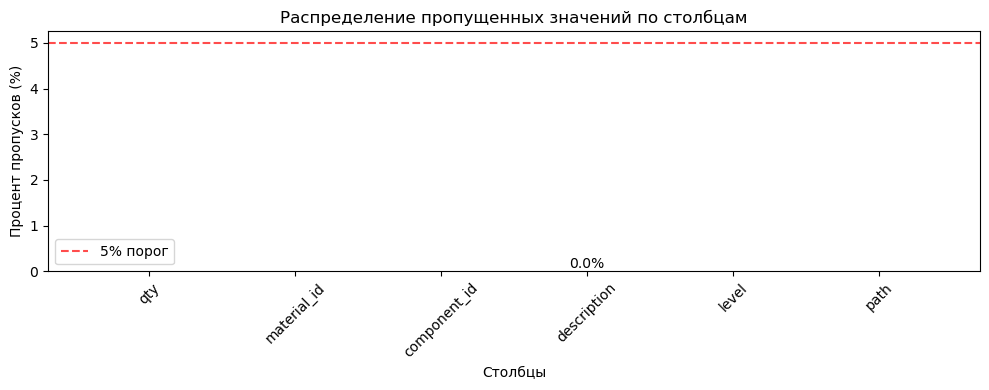

In [5]:
# Проверка пропущенных значений
print("\033[1;36m" + "ПРОВЕРКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ" + "\033[0m")
print("-" * 60)

missing_stats = df.isnull().sum()
missing_percent = (missing_stats / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Пропущено': missing_stats,
    'Процент': missing_percent
})

display(missing_df[missing_df['Пропущено'] > 0])

if missing_df['Пропущено'].sum() == 0:
    print("Пропущенных значений нет")
else:
    print(f"\nВсего пропущено значений: {missing_df['Пропущено'].sum()}")
    
    plt.figure(figsize=(10, 4))
    bars = plt.bar(missing_df.index, missing_df['Процент'], color='salmon')
    plt.axhline(y=5, color='red', linestyle='--', alpha=0.7, label='5% порог')
    plt.xlabel('Столбцы')
    plt.ylabel('Процент пропусков (%)')
    plt.title('Распределение пропущенных значений по столбцам')
    plt.xticks(rotation=45)
    plt.legend()
    
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

Пропущенные значения есть лишь в описании. Их процент очень мал, однако нужно изучить эти записи чтобы определить способ их обработки

In [6]:
# Проверка дубликатов
print("\033[1;36m" + "ПРОВЕРКА ДУБЛИКАТОВ" + "\033[0m")
print("-" * 60)

full_duplicates = df.duplicated().sum()
print(f"Полные дубликаты строк: {full_duplicates}")

key_duplicates = df.duplicated(subset=['material_id', 'component_id']).sum()
print(f"Дубликаты по (material_id, component_id): {key_duplicates}")

if key_duplicates > 0:
    print("\nПримеры дубликатов:")
    duplicates = df[df.duplicated(subset=['material_id', 'component_id'], keep=False)]
    display(duplicates.sort_values(['material_id', 'component_id']).head(10))
    
    duplicate_groups = duplicates.groupby(['material_id', 'component_id'])
    diff_counts = {}
    
    for (mat_id, comp_id), group in duplicate_groups:
        if len(group) > 1:
            diff_cols = []
            for col in ['qty', 'description', 'level', 'path']:
                if group[col].nunique() > 1:
                    diff_cols.append(col)
            if diff_cols:
                diff_counts[(mat_id, comp_id)] = diff_cols
    
    if diff_counts:
        print(f"\nДубликаты с различиями в данных:")
        for (mat_id, comp_id), cols in list(diff_counts.items())[:5]:
            print(f"  {mat_id} -> {comp_id}: различия в {cols}")

ПРОВЕРКА ДУБЛИКАТОВ
------------------------------------------------------------
Полные дубликаты строк: 0
Дубликаты по (material_id, component_id): 68826

Примеры дубликатов:


,qty,material_id,component_id,description,level,path
98404,2.0,00H6003,401102101,ROD END SPF5 5/16-24,2,00H6003.350355903.221217500.401102101
98428,2.0,00H6003,401102101,ROD END SPF5 5/16-24,2,00H6003.350355903.311031304.401102101
98327,49.0,00H6003,401690208,PIN SPIROL HVY 1/8 X .312LG HCP,1,00H6003.221265700.401690208
98349,386.0,00H6003,401690208,PIN SPIROL HVY 1/8 X .312LG HCP,2,00H6003.252400029.210900400.401690208
98468,4.0,00H6003,403660202,PIPE PLUG .75 SQ HD 304 SST,1,00H6003.350355903.403660202
98532,4.0,00H6003,403660202,PIPE PLUG .75 SQ HD 304 SST,1,00H6003.350912000.403660202
98305,2.0,00H6003,431512819,HHCS 3/8-16UNC-2A X 1.00 GR5,1,00H6003.221158200.431512819
98547,4.0,00H6003,431512819,HHCS 3/8-16UNC-2A X 1.00 GR5,1,00H6003.350923611.431512819
98405,2.0,00H6003,431512906,HHCS 5/16-18UNC-2A X 1.00 GR5,2,00H6003.350355903.221217500.431512906
98430,2.0,00H6003,431512906,HHCS 5/16-18UNC-2A X 1.00 GR5,2,00H6003.350355903.311031304.431512906



Дубликаты с различиями в данных:
  00H6003 -> 401102101: различия в ['path']
  00H6003 -> 401690208: различия в ['qty', 'level', 'path']
  00H6003 -> 403660202: различия в ['path']
  00H6003 -> 431512819: различия в ['qty', 'path']
  00H6003 -> 431512906: различия в ['path']


**Вывод по дубликатам:** 68,826 записей (10.6% данных) являются дубликатами по ключу (material_id, component_id), но с разными путями, уровнями и количествами. Это не ошибка данных, ведь один компонент может использоваться в сборке несколькими путями и в разном количестве на разных уровнях иерархии. Для приложения это означает необходимость учета всех путей использования компонента и корректной обработки графовых связей. 

Хорошо, что description одинаковый. Лайк

АНАЛИЗ КОЛИЧЕСТВЕННЫХ ДАННЫХ
------------------------------------------------------------
Статистика qty:
count    649253.000000
mean          4.258545
std          18.258876
min           0.020000
25%           1.000000
50%           1.000000
75%           2.000000
max        3600.000000
Name: qty, dtype: float64

Минимальное значение: 0.02
Максимальное значение: 3600.0

Количество записей с qty = 0: 0
Количество записей с qty < 0: 0


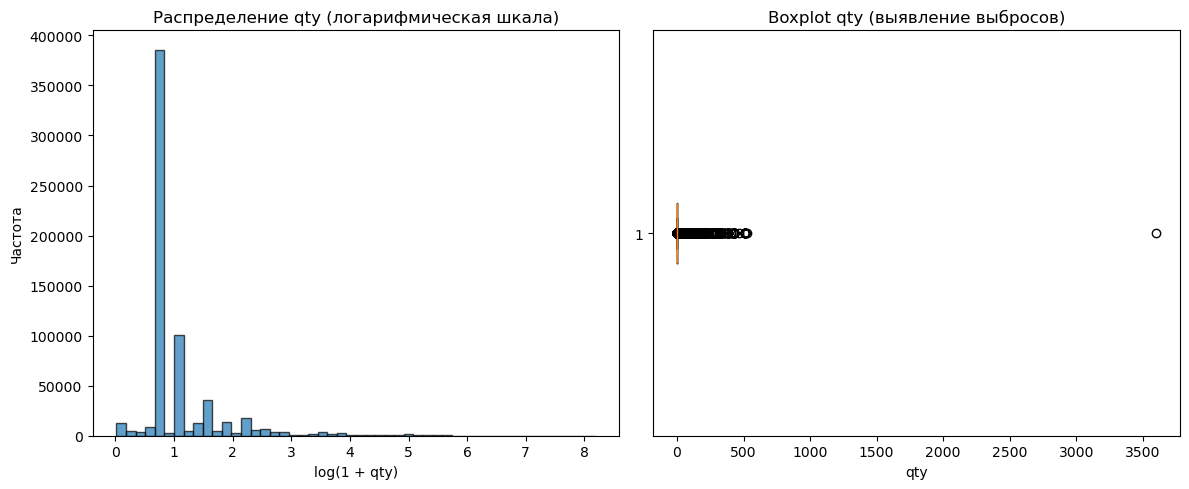


Самые частые значения qty:
  qty=1.0: 380680 записей (58.6%)
  qty=2.0: 96579 записей (14.9%)
  qty=4.0: 32271 записей (5.0%)
  qty=8.0: 14917 записей (2.3%)
  qty=3.0: 10863 записей (1.7%)
  qty=6.0: 8990 записей (1.4%)
  qty=12.0: 4168 записей (0.6%)
  qty=1.12: 3261 записей (0.5%)
  qty=0.04: 2995 записей (0.5%)
  qty=16.0: 2981 записей (0.5%)


In [7]:
# Анализ количественных значений
print("\033[1;36m" + "АНАЛИЗ КОЛИЧЕСТВЕННЫХ ДАННЫХ" + "\033[0m")
print("-" * 60)

print("Статистика qty:")
print(df['qty'].describe())

print(f"\nМинимальное значение: {df['qty'].min()}")
print(f"Максимальное значение: {df['qty'].max()}")

zero_qty = (df['qty'] == 0).sum()
negative_qty = (df['qty'] < 0).sum()

print(f"\nКоличество записей с qty = 0: {zero_qty}")
print(f"Количество записей с qty < 0: {negative_qty}")

if zero_qty > 0 or negative_qty > 0:
    print("\nПримеры проблемных записей:")
    problems = df[(df['qty'] <= 0)]
    display(problems.head())

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
log_qty = np.log1p(df['qty'])
plt.hist(log_qty, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('log(1 + qty)')
plt.ylabel('Частота')
plt.title('Распределение qty (логарифмическая шкала)')

plt.subplot(1, 2, 2)
plt.boxplot(df['qty'], vert=False)
plt.xlabel('qty')
plt.title('Boxplot qty (выявление выбросов)')

plt.tight_layout()
plt.show()

print("\nСамые частые значения qty:")
top_qty = df['qty'].value_counts().head(10)
for value, count in top_qty.items():
    print(f"  qty={value}: {count} записей ({count/len(df)*100:.1f}%)")

**Вывод по qty:**

Данные показывают стандартную картину для механических сборок: большинство компонентов используются поштучно (58.6% - 1 шт, 14.9% - 2 шт). Нет проблемных значений (нет нулей и отрицательных чисел).

Присутствуют аномалии: есть детали с очень большим количеством (до 3600 шт) и дробные значения (0.02, 1.12), что говорит о разных типах материалов в одном поле - от крупных деталей до мелкого крепежа и сыпучих материалов.


In [8]:
# Анализ уникальных идентификаторов
print("\033[1;36m" + "АНАЛИЗ УНИКАЛЬНЫХ ИДЕНТИФИКАТОРОВ" + "\033[0m")
print("-" * 60)

print(f"Уникальных material_id: {df['material_id'].nunique()}")
print(f"Уникальных component_id: {df['component_id'].nunique()}")

material_set = set(df['material_id'].unique())
component_set = set(df['component_id'].unique())

intersection = material_set.intersection(component_set)
print(f"\nID встречаются и как material_id и как component_id: {len(intersection)}")
if intersection:
    print(f"Примеры: {list(intersection)[:5]}")

orphan_components = component_set - material_set
print(f"\nКомпоненты которые не являются сборками: {len(orphan_components)}")

root_materials = material_set - component_set
print(f"Корневые узлы (только сборки не компоненты): {len(root_materials)}")

self_references = df[df['material_id'] == df['component_id']]
print(f"\nСамоссылки (material_id == component_id): {len(self_references)}")
if len(self_references) > 0:
    print("Примеры самоссылок:")
    display(self_references.head())

АНАЛИЗ УНИКАЛЬНЫХ ИДЕНТИФИКАТОРОВ
------------------------------------------------------------
Уникальных material_id: 1884
Уникальных component_id: 15751

ID встречаются и как material_id и как component_id: 1884
Примеры: ['03H6826', '03T7058', '06H7628', '02H6606', '02T6515']

Компоненты которые не являются сборками: 13867
Корневые узлы (только сборки не компоненты): 0

Самоссылки (material_id == component_id): 1884
Примеры самоссылок:


,qty,material_id,component_id,description,level,path
0,1.0,00H6016,00H6016,Assembly 00H6016,0,00H6016
397,1.0,00H6071,00H6071,Assembly 00H6071,0,00H6071
820,1.0,00H6154,00H6154,Assembly 00H6154,0,00H6154
1166,1.0,00H6168,00H6168,Assembly 00H6168,0,00H6168
1502,1.0,00T6029,00T6029,Assembly 00T6029,0,00T6029


- Все 1884 сборок также являются компонентами, что создает полное пересечение множеств, круто.
- Из 15751 уникальных компонентов 13867 (88%) — это конечные детали, которые никогда не выступают как сборки.


### Анализ иерархической структуры

АНАЛИЗ ИЕРАРХИЧЕСКОЙ СТРУКТУРЫ
------------------------------------------------------------
Статистика по уровням вложенности:
count    649253.000000
mean          1.440993
std           0.896224
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           9.000000
Name: level, dtype: float64

Максимальный уровень вложенности: 9


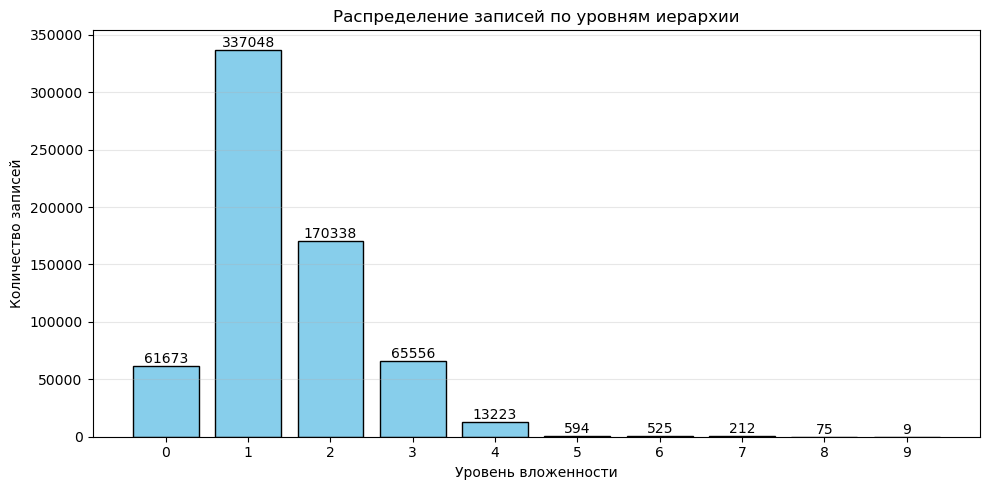


СООТВЕТСТВИЕ УРОВНЯ И ГЛУБИНЫ ПУТИ
----------------------------------------


,Уровень,Глубина пути,Записей,Процент на уровне,Разница (depth - (level+1))
0,0,1,1884,3.1%,0
1,0,2,59789,96.9%,1
2,1,2,16,0.0%,0
3,1,3,337032,100.0%,1
4,2,3,64,0.0%,0
5,2,4,170274,100.0%,1
6,3,4,98,0.1%,0
7,3,5,65458,99.9%,1
8,4,5,410,3.1%,0
9,4,6,12813,96.9%,1


In [9]:
# Анализ структуры иерархии
print("\033[1;36m" + "АНАЛИЗ ИЕРАРХИЧЕСКОЙ СТРУКТУРЫ" + "\033[0m")
print("-" * 60)

print("Статистика по уровням вложенности:")
print(df['level'].describe())

level_distribution = df['level'].value_counts().sort_index()

# Максимальная глубина
max_level = df['level'].max()
print(f"\nМаксимальный уровень вложенности: {max_level}")

# Визуализация распределения уровней
plt.figure(figsize=(10, 5))
bars = plt.bar(level_distribution.index, level_distribution.values, color='skyblue', edgecolor='black')
plt.xlabel('Уровень вложенности')
plt.ylabel('Количество записей')
plt.title('Распределение записей по уровням иерархии')
plt.xticks(range(0, max_level + 1))

# Добавление значений на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Анализ глубины путей
df['path_depth'] = df['path'].str.split('.').str.len()

print("\n\033[1;35m" + "СООТВЕТСТВИЕ УРОВНЯ И ГЛУБИНЫ ПУТИ" + "\033[0m")
print("-" * 40)

# Создаем таблицу-датафрейм
level_depth_table = []

for level in sorted(df['level'].unique()):
    level_data = df[df['level'] == level]
    unique_depths = sorted(level_data['path_depth'].unique())
    
    for depth in unique_depths:
        count = len(level_data[level_data['path_depth'] == depth])
        percentage = count / len(level_data) * 100
        diff = depth - (level + 1)
        
        level_depth_table.append({
            'Уровень': level,
            'Глубина пути': depth,
            'Записей': count,
            'Процент на уровне': f'{percentage:.1f}%',
            'Разница (depth - (level+1))': diff
        })

# Создаем датафрейм и показываем
level_depth_df = pd.DataFrame(level_depth_table)
level_depth_df = level_depth_df.sort_values(['Уровень', 'Глубина пути'])
display(level_depth_df.head(15))


**Вывод анализа иерархической структуры:**

Данные содержат несоответствие между двумя системами нумерации уровней. Поле `level` показывает относительную глубину от непосредственного родителя (0 для прямых компонентов сборки, 1 для компонентов компонентов), а `path` отражает абсолютный путь от корневого узла.

Для каждого значения `level` существует два типа записей. минимальное количество (0-3%) с глубиной пути `level + 1` и большинство (97-100%) с глубиной `level + 2`. 

Для корректного отображения иерархии в приложении необходимо использовать поле `path` как основной источник информации о структуре, вычисляя абсолютный уровень как `path_depth - 2`. Поле `level` не совсем информативен.


АНАЛИЗ ПУТЕЙ
------------------------------------------------------------
Анализ формата путей:
Пути с некорректными символами: 48

НЕКОРРЕКТНЫЕ ПУТИ (первые 10):
----------------------------------------
  Путь: 02T6713R.CTD COV/CSG REPAIR
    Некорректные символы: '/', ' '
    Уровень: 0, material_id: 02T6713R, component_id: CTD COV/CSG REPAIR

  Путь: 02T6713R.CTD ROTOR REPAIR
    Некорректные символы: ' '
    Уровень: 0, material_id: 02T6713R, component_id: CTD ROTOR REPAIR

  Путь: 02T6713R.CTD VLV BDY REPAIR
    Некорректные символы: ' '
    Уровень: 0, material_id: 02T6713R, component_id: CTD VLV BDY REPAIR

  Путь: 02T6713R.INSTRUCTION MANUAL
    Некорректные символы: ' '
    Уровень: 0, material_id: 02T6713R, component_id: INSTRUCTION MANUAL

  Путь: 02T6713R.USED GOV MED
    Некорректные символы: ' '
    Уровень: 0, material_id: 02T6713R, component_id: USED GOV MED

  Путь: 04T7152R.CTD CASING REPAIR
    Некорректные символы: ' '
    Уровень: 0, material_id: 04T7152R, componen

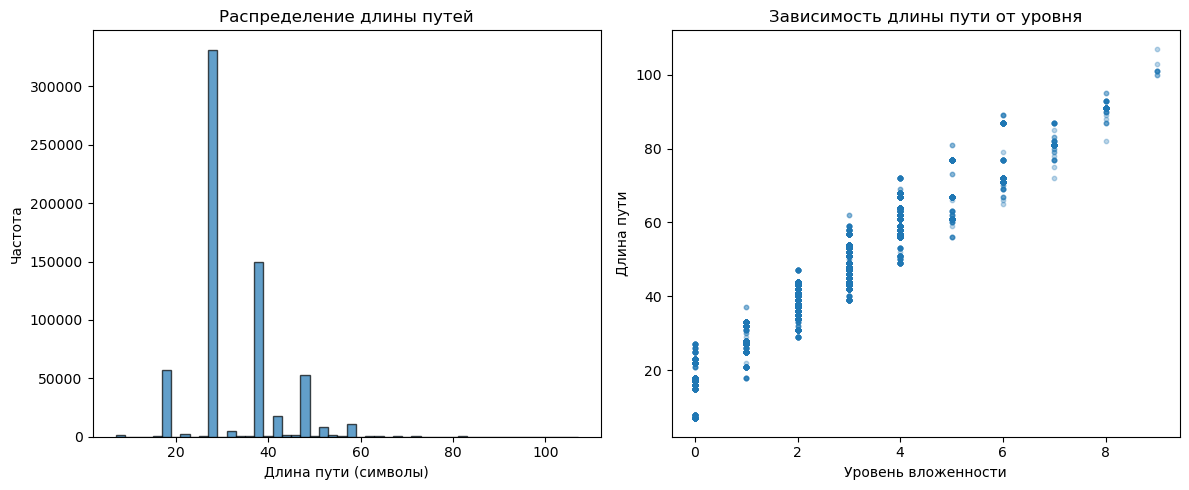

In [10]:
# Анализ путей
print("\033[1;36m" + "АНАЛИЗ ПУТЕЙ" + "\033[0m")
print("-" * 60)

print("Анализ формата путей:")

# Поиск путей с некорректными символами
paths_with_wrong_sep = df[~df['path'].str.contains('^[A-Za-z0-9_.-]+$', na=False)]
print(f"Пути с некорректными символами: {len(paths_with_wrong_sep)}")

# Показываем найденные некорректные пути
if len(paths_with_wrong_sep) > 0:
    print("\n\033[1;35m" + "НЕКОРРЕКТНЫЕ ПУТИ (первые 10):" + "\033[0m")
    print("-" * 40)
    
    for idx, row in paths_with_wrong_sep.head(10).iterrows():
        path = row['path']
        # Находим некорректные символы
        invalid_chars = re.findall(r'[^A-Za-z0-9_.-]', str(path))
        invalid_chars_str = ', '.join([f"'{c}'" for c in set(invalid_chars)])
        
        print(f"  Путь: {path}")
        print(f"    Некорректные символы: {invalid_chars_str}")
        print(f"    Уровень: {row['level']}, material_id: {row['material_id']}, component_id: {row['component_id']}")
        print()

# Проверка других проблем формата
paths_starting_with_dot = df[df['path'].str.startswith('.', na=False)]
paths_ending_with_dot = df[df['path'].str.endswith('.', na=False)]
print(f"Пути начинающиеся с точки: {len(paths_starting_with_dot)}")
print(f"Пути заканчивающиеся точкой: {len(paths_ending_with_dot)}")

paths_with_double_dots = df[df['path'].str.contains('\.\.', na=False)]
print(f"Пути с двойными точками: {len(paths_with_double_dots)}")

# Добавляем длину пути как столбец в DataFrame
df['path_length'] = df['path'].str.len()
path_lengths = df['path_length']

print(f"\nСтатистика длины путей:")
print(f"  Минимальная: {path_lengths.min()}")
print(f"  Средняя: {path_lengths.mean():.1f}")
print(f"  Максимальная: {path_lengths.max()}")

# Визуализация
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(path_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Длина пути (символы)')
plt.ylabel('Частота')
plt.title('Распределение длины путей')

plt.subplot(1, 2, 2)
plt.scatter(df['level'], path_lengths, alpha=0.3, s=10)
plt.xlabel('Уровень вложенности')
plt.ylabel('Длина пути')
plt.title('Зависимость длины пути от уровня')

plt.tight_layout()
plt.show()

**Вывод:** Пути в данных в целом корректно составлены, отсутствуют критические ошибки вроде путей с двойными точками или неправильными разделителями. Однако обнаружено 48 записей с некорректными component_id, содержащими пробелы и слеши, что нарушает стандартную нотацию идентификаторов и может вызвать проблемы при парсинге.

Будет необходимо бработать проблемные записи путем замены пробелов и специальных символов на дефисы или подчеркивания, например преобразовать `'CTD COV/CSG REPAIR'` в `'CTD-COV-CSG-REPAIR'`. Для предотвращения подобных ошибок в будущем необходимо добавить валидацию на этапе импорта данных, запрещающую использование пробелов и нестандартных символов в полях идентификаторов.


### Анализ описаний 

In [11]:
# Детальный анализ пропущенных описаний
print("\033[1;36m" + "ДЕТАЛЬНЫЙ АНАЛИЗ ПРОПУЩЕННЫХ ОПИСАНИЙ" + "\033[0m")
print("-" * 60)

missing_desc = df[df['description'].isnull()].copy()
print(f"Найдено записей с пропущенными описаниями: {len(missing_desc)}")

if len(missing_desc) > 0:
    print("\n\033[1;35m" + "РАСПРЕДЕЛЕНИЕ ПО УРОВНЯМ:" + "\033[0m")
    level_dist = missing_desc['level'].value_counts().sort_index()
    total_missing = len(missing_desc)
    levels_4_6 = 0
    
    for level, count in level_dist.items():
        percentage = count/total_missing*100
        print(f"  Уровень {level}: {count} записей ({percentage:.1f}%)")
        if level in [4, 6]:
            levels_4_6 += count
    
    print(f"\n  Уровни 4 и 6 содержат {levels_4_6} записей ({levels_4_6/total_missing*100:.1f}% всех пропусков)")
    
    print("\n\033[1;35m" + "АНАЛИЗ ДУБЛИРОВАНИЯ:" + "\033[0m")
    missing_components = missing_desc['component_id'].unique()
    print(f"  Уникальных component_id с пропусками: {len(missing_components)}")
    
    # Доказываем, что компоненты не имеют описаний нигде
    components_without_any_description = []
    components_with_some_description = []
    
    for comp_id in missing_components:
        all_entries = df[df['component_id'] == comp_id]
        has_description = all_entries['description'].notna().any()
        
        if not has_description:
            components_without_any_description.append(comp_id)
        else:
            components_with_some_description.append(comp_id)
    
    print(f"  Компоненты без описаний вообще: {len(components_without_any_description)}")
    print(f"  Компоненты с описаниями в других записях: {len(components_with_some_description)}")
    
    # Если есть компоненты с описаниями - показываем доказательство
    if len(components_with_some_description) > 0:
        print("  \033[1;31mДОКАЗАТЕЛЬСТВО НАЙДЕННЫХ ОПИСАНИЙ:\033[0m")
        for comp_id in components_with_some_description[:3]:
            all_entries = df[df['component_id'] == comp_id]
            desc_entry = all_entries[all_entries['description'].notna()].iloc[0]
            print(f"    {comp_id}: '{desc_entry['description'][:60]}...'")
    else:
        print(f"\033[1;32mДОКАЗАТЕЛЬСТВО: Ни один из {len(missing_components)} компонентов не имеет описаний ни в одной записи датасета\033[0m")
    
    # Анализируем паттерны ID
    print("\n\033[1;35m" + "АНАЛИЗ ПАТТЕРНОВ COMPONENT_ID:" + "\033[0m")
    
    # Группируем по префиксам
    prefix_patterns = {}
    for comp_id in missing_components:
        comp_str = str(comp_id)
        # Определяем префикс (первые 3 цифры или символы)
        if comp_str[:3].isdigit():
            prefix = comp_str[:3]
        elif '-' in comp_str:
            prefix = comp_str.split('-')[0][:6]
        else:
            prefix = comp_str[:3]
        
        if prefix not in prefix_patterns:
            prefix_patterns[prefix] = []
        prefix_patterns[prefix].append(comp_id)
    
    print("  Основные паттерны префиксов:")
    for prefix, comps in sorted(prefix_patterns.items(), key=lambda x: len(x[1]), reverse=True)[:5]:
        print(f"    {prefix}xxx: {len(comps)} компонентов (пример: {comps[0]})")
    
    print("\n\033[1;35m" + "ГРАФОВЫЙ АНАЛИЗ:" + "\033[0m")
    G_temp = nx.DiGraph()
    for _, row in df.iterrows():
        if pd.notna(row['material_id']) and pd.notna(row['component_id']):
            G_temp.add_edge(row['material_id'], row['component_id'])
    
    # Доказываем, что это конечные детали (не сборки)
    assemblies_count = 0
    leaves_count = 0
    in_degrees = []
    
    for comp_id in missing_components:
        # Проверяем, является ли компонент сборкой (имеет исходящие ребра)
        is_assembly = G_temp.out_degree(comp_id) > 0
        in_degree = G_temp.in_degree(comp_id)
        
        if is_assembly:
            assemblies_count += 1
        else:
            leaves_count += 1
        
        in_degrees.append(in_degree)
    
    print(f"  Являются сборками (имеют компоненты): {assemblies_count}")
    print(f"  Являются конечными деталями (листья): {leaves_count}")
    print(f"  Среднее количество родительских сборок: {np.mean(in_degrees):.1f}")
    print(f"  Максимальное количество родительских сборок: {np.max(in_degrees)}")
    
    # Показываем примеры использования в разных сборках
    print("\n  Примеры повторного использования компонентов:")
    multi_use_components = [(comp_id, G_temp.in_degree(comp_id)) 
                          for comp_id in missing_components 
                          if G_temp.in_degree(comp_id) > 1]
    
    for comp_id, usage_count in multi_use_components[:3]:
        # Находим все сборки, где используется этот компонент
        parent_assemblies = []
        for edge in G_temp.in_edges(comp_id):
            parent_assemblies.append(edge[0])
        
        print(f"    {comp_id}: используется в {usage_count} сборках")
        print(f"      Сборки: {', '.join(parent_assemblies[:3])}{'...' if len(parent_assemblies) > 3 else ''}")
    
    # Анализ глубины вложенности
    print("\n\033[1;35m" + "АНАЛИЗ ГЛУБИНЫ ВЛОЖЕННОСТИ:" + "\033[0m")
    
    missing_desc['path_depth'] = missing_desc['path'].str.split('.').str.len()
    depth_counts = missing_desc['path_depth'].value_counts().sort_index()
    
    print("  Распределение по глубине путей:")
    for depth, count in depth_counts.items():
        print(f"    Глубина {depth}: {count} записей ({count/total_missing*100:.1f}%)")
    
    depths_5_9 = sum(count for depth, count in depth_counts.items() if depth >= 5 and depth <= 9)
    print(f"\n  Глубины 5-9 содержат {depths_5_9} записей ({depths_5_9/total_missing*100:.1f}% всех пропусков)")
    
    print("\n\033[1;35m" + "ПРИМЕРЫ ПУТЕЙ С ПРОПУЩЕННЫМИ ОПИСАНИЯМИ:" + "\033[0m")
    for path in missing_desc['path'].head(3).values:
        print(f"  {path}")
        
        parts = path.split('.')
        if len(parts) > 1:
            parent = parts[-2]
            parent_desc = df[df['component_id'] == parent]['description']
            if not parent_desc.empty and parent_desc.iloc[0]:
                print(f"    Родительский узел: {parent} - {parent_desc.iloc[0][:40]}...")

ДЕТАЛЬНЫЙ АНАЛИЗ ПРОПУЩЕННЫХ ОПИСАНИЙ
------------------------------------------------------------
Найдено записей с пропущенными описаниями: 62

РАСПРЕДЕЛЕНИЕ ПО УРОВНЯМ:
  Уровень 4: 25 записей (40.3%)
  Уровень 5: 1 записей (1.6%)
  Уровень 6: 29 записей (46.8%)
  Уровень 7: 5 записей (8.1%)
  Уровень 8: 2 записей (3.2%)

  Уровни 4 и 6 содержат 54 записей (87.1% всех пропусков)

АНАЛИЗ ДУБЛИРОВАНИЯ:
  Уникальных component_id с пропусками: 32
  Компоненты без описаний вообще: 32
  Компоненты с описаниями в других записях: 0
ДОКАЗАТЕЛЬСТВО: Ни один из 32 компонентов не имеет описаний ни в одной записи датасета

АНАЛИЗ ПАТТЕРНОВ COMPONENT_ID:
  Основные паттерны префиксов:
    910xxx: 7 компонентов (пример: 910683306)
    921xxx: 5 компонентов (пример: 921216701)
    911xxx: 5 компонентов (пример: 911055100)
    931xxx: 3 компонентов (пример: 931504400)
    259xxx: 2 компонентов (пример: 259930108)

ГРАФОВЫЙ АНАЛИЗ:
  Являются сборками (имеют компоненты): 0
  Являются конечными деталя

**Вывод**

**Во-первых, все 32 уникальных component_id с пропусками не имеют описаний ни в одной записи датасета** (анализ дублирования показал 0 компонентов с описаниями в других записях). Это указывает на то, что данные компоненты были импортированы или созданы без метаданных, возможно из внешних систем без описания.

**Во-вторых, распределение по уровням иерархии (преимущественно уровни 4 и 6, 87% всех пропусков) и глубина путей (5-9 уровней)** свидетельствует о том, что пропуски сосредоточены во вложенных компонентах сложных сборок. Эти компоненты являются конечными деталями (не сборками), что подтверждается графовым анализом (0 сборок среди пропусков).

**В-третьих, паттерны component_id (910xxx, 921xxx, 2599xxx, 6116xxx-000) и их повторяемость в разных сборках** (среднее количество родительских сборок 2.5) указывают на то, что это стандартизированные компоненты, возможно, из каталогов производителей. Отсутствие описаний может быть связано с тем, что в исходных системах они идентифицировались только по каталожным номерам, без читаемых описаний.


АНАЛИЗ ОПИСАНИЙ
------------------------------------------------------------
Всего записей: 649253
Записей с описаниями: 649191
Пропущенных описаний (NaN): 62 (0.01%)
Записей с текстом 'nan' (не пропуски): 0 (0.00%)

Уникальных описаний (не пустых): 15106
Процент уникальных среди непустых: 2.3%

СТАТИСТИКА ДЛИНЫ ВАЛИДНЫХ ОПИСАНИЙ:
  Всего валидных описаний: 649191
  Символов: мин=3, сред=25.0, макс=78
  Слов: мин=1, сред=4.9, макс=15


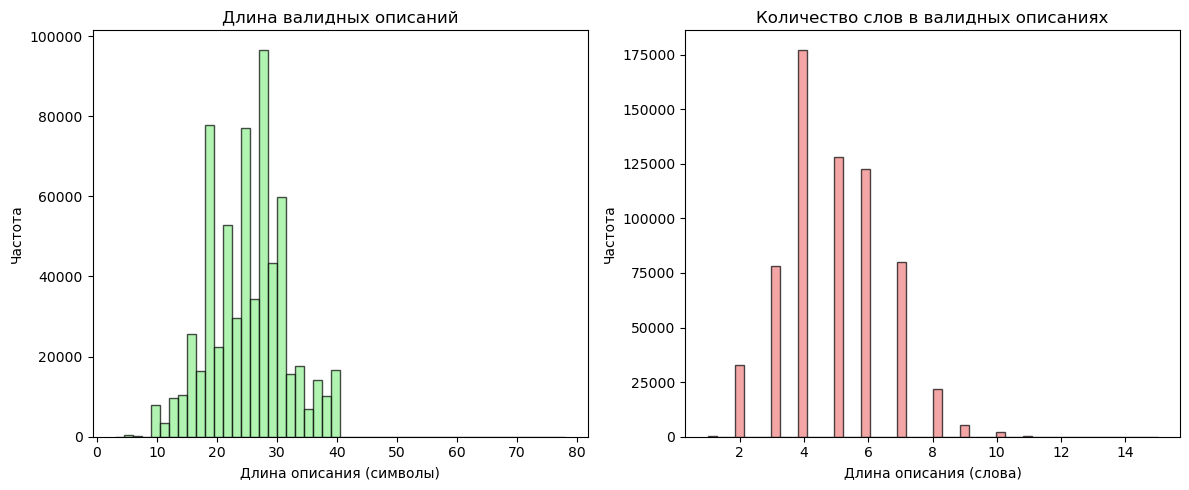


ТОП-5 САМЫХ ДЛИННЫХ ОПИСАНИЙ:

  01H6347 -> 831527356:
    Длина: 78 символов
    Описание: 'SHAFT BLK 2.62DIA X 38LG 4140  FGD CMTR // ***MUST BE PICKED FROM STOCKROOM***'
    Содержит служебный комментарий (//)

  01H6348 -> 831527356:
    Длина: 78 символов
    Описание: 'SHAFT BLK 2.62DIA X 38LG 4140  FGD CMTR // ***MUST BE PICKED FROM STOCKROOM***'
    Содержит служебный комментарий (//)

  04T7171 -> 820695559:
    Длина: 78 символов
    Описание: 'WHEEL BLANK 22-23 4140 FGD 195 BHN OMTR // ***MUST BE PICKED FROM STOCKROOM***'
    Содержит служебный комментарий (//)

  01T6402 -> 831269100:
    Длина: 77 символов
    Описание: 'WHL TURB12 4140 FGD NORM/ANNEAL B09155 // ***MUST BE PICKED FROM STOCKROOM***'
    Содержит служебный комментарий (//)

  00H6100 -> 841914700:
    Длина: 77 символов
    Описание: '3.12 DIA X 37.12 LG A434 4140-50 HT UT // ***MUST BE PICKED FROM STOCKROOM***'
    Содержит служебный комментарий (//)

ТОП-5 САМЫХ КОРОТКИХ НЕПУСТЫХ ОПИСАНИЙ:
  02H6542 -> 1S

In [12]:
# Анализ описаний
print("\033[1;36m" + "АНАЛИЗ ОПИСАНИЙ" + "\033[0m")
print("-" * 60)

print(f"Всего записей: {len(df)}")
print(f"Записей с описаниями: {df['description'].notna().sum()}")
print(f"Пропущенных описаний (NaN): {df['description'].isnull().sum()} ({df['description'].isnull().sum()/len(df)*100:.2f}%)")

# Создаем временные копии для анализа
desc_series = df['description'].copy()
desc_as_str = desc_series.fillna('').astype(str)

# Анализ строк 'nan' как текста (не пропусков)
nan_as_text = desc_as_str[desc_as_str.str.lower() == 'nan']
print(f"Записей с текстом 'nan' (не пропуски): {len(nan_as_text)} ({len(nan_as_text)/len(df)*100:.2f}%)")

# Анализ уникальности среди непустых описаний
non_empty_descriptions = desc_as_str[desc_as_str != '']
unique_descriptions = non_empty_descriptions.nunique()
print(f"\nУникальных описаний (не пустых): {unique_descriptions}")
print(f"Процент уникальных среди непустых: {unique_descriptions/len(non_empty_descriptions)*100:.1f}%")

# Статистика длины (исключая пустые и 'nan')
valid_for_length = desc_as_str[~desc_as_str.isin(['', 'nan'])]
if len(valid_for_length) > 0:
    char_lengths = valid_for_length.str.len()
    word_counts = valid_for_length.str.split().str.len()
    
    print(f"\n\033[1;35m" + "СТАТИСТИКА ДЛИНЫ ВАЛИДНЫХ ОПИСАНИЙ:" + "\033[0m")
    print(f"  Всего валидных описаний: {len(valid_for_length)}")
    print(f"  Символов: мин={char_lengths.min()}, сред={char_lengths.mean():.1f}, макс={char_lengths.max()}")
    print(f"  Слов: мин={word_counts.min()}, сред={word_counts.mean():.1f}, макс={word_counts.max()}")

# Визуализация длины валидных описаний
if len(valid_for_length) > 0:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(char_lengths, bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
    plt.xlabel('Длина описания (символы)')
    plt.ylabel('Частота')
    plt.title('Длина валидных описаний')
    
    plt.subplot(1, 2, 2)
    plt.hist(word_counts, bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
    plt.xlabel('Длина описания (слова)')
    plt.ylabel('Частота')
    plt.title('Количество слов в валидных описаниях')
    
    plt.tight_layout()
    plt.show()

# Анализ самых длинных описаний
print("\n\033[1;35m" + "ТОП-5 САМЫХ ДЛИННЫХ ОПИСАНИЙ:" + "\033[0m")
if len(valid_for_length) > 0:
    # Создаем временный датафрейм для анализа
    temp_df = df.copy()
    temp_df['desc_str'] = desc_as_str
    temp_df['desc_length'] = desc_as_str.str.len()
    
    # Фильтруем валидные описания
    valid_temp = temp_df[~temp_df['desc_str'].isin(['', 'nan'])]
    
    if len(valid_temp) > 0:
        longest = valid_temp.nlargest(5, 'desc_length')
        for idx, row in longest.iterrows():
            print(f"\n  {row['material_id']} -> {row['component_id']}:")
            print(f"    Длина: {row['desc_length']} символов")
            print(f"    Описание: '{row['description']}'")
            
            # Анализируем структуру без изменения
            if isinstance(row['description'], str):
                if '//' in row['description']:
                    print(f"    Содержит служебный комментарий (//)")

# Анализ самых коротких непустых описаний
print("\n\033[1;35m" + "ТОП-5 САМЫХ КОРОТКИХ НЕПУСТЫХ ОПИСАНИЙ:" + "\033[0m")
if len(valid_for_length) > 0:
    shortest = valid_temp[valid_temp['desc_length'] > 0].nsmallest(5, 'desc_length')
    for idx, row in shortest.iterrows():
        print(f"  {row['material_id']} -> {row['component_id']}: '{row['description']}' ({row['desc_length']} симв.)")

**Вывод**  При средней длине 25 символов и 5 слов встречаются как минималистичные записи 'nan' (технические пропуски), так и перегруженные описания с комментариями о складском хранении длиной до 78 символов.

Необходимо очистить описания от служебных комментариев (// MUST BE PICKED FROM STOCKROOM) и заполнить пропуски ('nan') на основе контекста использования компонентов. Для векторизации следует выделять технические характеристики в отдельные поля, оставляя в описании только значимую часть.


АНАЛИЗ СПЕЦИАЛЬНЫХ СИМВОЛОВ И ФОРМАТИРОВАНИЯ
------------------------------------------------------------
Всего записей: 649,253
Валидных описаний: 649,191
Длина описаний: 3-78 символов

1. СПЕЦИАЛЬНЫЕ СИМВОЛЫ:
  Скобки [](){}: 2,300 (0.4%)
  Слеши /\|: 218,788 (33.7%)
  Тире -–—: 210,768 (32.5%)
  Спецсимволы #@$%^&*+=~: 31,692 (4.9%)
  Кавычки '": 5,726 (0.9%)

2. ФОРМАТИРОВАНИЕ ТЕКСТА:
  Только заглавные (CAPS LOCK): 400,679 (61.7%)
  Смешанный регистр: 3,037 (0.5%)
  Текст в круглых скобках (): 2,037 (0.3%)
  Текст в квадратных скобках []: 125 (0.0%)
  Служебные комментарии //: 281 (0.0%)
  Выделение **: 267 (0.0%)


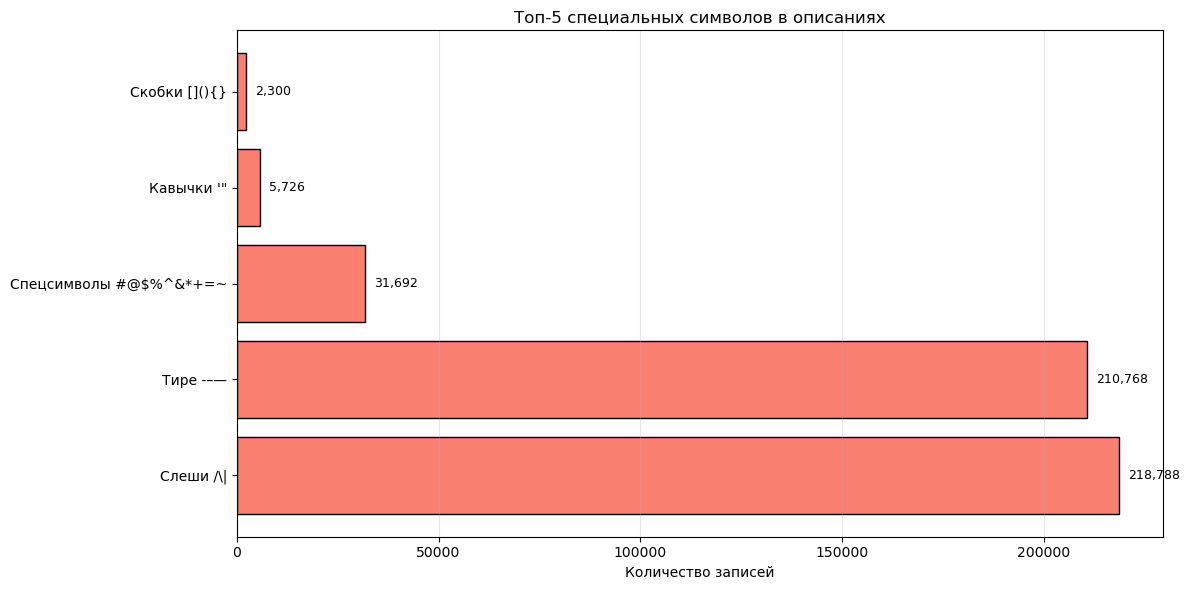

In [13]:
# Анализ специальных символов и форматирования
print("\033[1;36m" + "АНАЛИЗ СПЕЦИАЛЬНЫХ СИМВОЛОВ И ФОРМАТИРОВАНИЯ" + "\033[0m")
print("-" * 60)

# Подготовка данных
desc_series = df['description'].copy()
desc_as_str = desc_series.fillna('').astype(str)
valid_descriptions = desc_as_str[~desc_as_str.isin(['', 'nan'])]

print(f"Всего записей: {len(df):,}")
print(f"Валидных описаний: {len(valid_descriptions):,}")
print(f"Длина описаний: {valid_descriptions.str.len().min()}-{valid_descriptions.str.len().max()} символов")

# 1. Специальные символы
print("\n\033[1;35m" + "1. СПЕЦИАЛЬНЫЕ СИМВОЛЫ:" + "\033[0m")

special_char_patterns = {
    'Скобки [](){}': r'[\[\](){}]',
    'Слеши /\\|': r'[/\\|]',
    'Тире -–—': r'[-–—]',
    'Спецсимволы #@$%^&*+=~': r'[#@$%^&*+=~]',
    'Кавычки \'\"': r'[\'"]'
}

special_char_stats = {}
for char_type, pattern in special_char_patterns.items():
    count = valid_descriptions.str.contains(pattern).sum()
    special_char_stats[char_type] = count
    percentage = count/len(valid_descriptions)*100
    print(f"  {char_type}: {count:,} ({percentage:.1f}%)")

# 2. Форматирование текста
print("\n\033[1;35m" + "2. ФОРМАТИРОВАНИЕ ТЕКСТА:" + "\033[0m")

format_patterns = {
    'Только заглавные (CAPS LOCK)': r'^[A-Z0-9\s\.\-]+$',
    'Смешанный регистр': r'[a-z].*[A-Z]|[A-Z].*[a-z]',
    'Текст в круглых скобках ()': r'\([^)]+\)',
    'Текст в квадратных скобках []': r'\[[^\]]+\]',
    'Служебные комментарии //': r'//',
    'Выделение **': r'\*\*+',
}

format_counts = {}
for pattern_name, pattern in format_patterns.items():
    count = valid_descriptions.str.contains(pattern).sum()
    format_counts[pattern_name] = count
    percentage = count/len(valid_descriptions)*100
    print(f"  {pattern_name}: {count:,} ({percentage:.1f}%)")

# график со специальными символами
plt.figure(figsize=(12, 6))

# Берем топ-5 специальных символов по частоте
sorted_chars = sorted(special_char_stats.items(), key=lambda x: x[1], reverse=True)
top_chars = dict(sorted_chars[:5])

bars = plt.barh(list(top_chars.keys()), list(top_chars.values()), color='salmon', edgecolor='black')
plt.xlabel('Количество записей')
plt.title('Топ-5 специальных символов в описаниях')
plt.grid(axis='x', alpha=0.3)

# Добавляем значения на столбцы
for bar in bars:
    width = bar.get_width()
    plt.text(width + max(top_chars.values())*0.01, bar.get_y() + bar.get_height()/2,
             f'{int(width):,}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [14]:
# Анализ технических характеристик и материалов
print("\033[1;36m" + "АНАЛИЗ ТЕХНИЧЕСКИХ ХАРАКТЕРИСТИК И МАТЕРИАЛОВ" + "\033[0m")
print("-" * 60)

# 1. Технические характеристики
print("\n\033[1;35m" + "1. ТЕХНИЧЕСКИЕ ХАРАКТЕРИСТИКИ:" + "\033[0m")

tech_patterns = {
    'Размеры (число×число)': r'\d+[\.\,]?\d*\s*[хxX×]\s*\d+[\.\,]?\d*',
    'Размеры с мм/дюймы': r'\d+[\.\,]?\d*\s*(mm|in|inch|дюйм|мм)\b',
    'Диаметры (DIA)': r'\d+[\.\,]?\d*\s*DIA',
    'Длины (LG)': r'\d+[\.\,]?\d*\s*LG',
    'Резьба (UNC/UNF/NPT)': r'\d+[\.\,]?\d*\s*[-/]\s*\d+\s*(UNC|UNF|NPT)',
    'Классы точности (CLASS/GR)': r'CLASS\s+\d+|GR\s*\d+',
    'Твердость (BHN/HRC/HB)': r'\d+\s*(BHN|HRC|HB)',
}

tech_results = {}
for pattern_name, pattern in tech_patterns.items():
    count = valid_descriptions.str.contains(pattern, flags=re.IGNORECASE, na=False).sum()
    tech_results[pattern_name] = count
    percentage = count/len(valid_descriptions)*100
    print(f"  {pattern_name}: {count:,} ({percentage:.1f}%)")

# 2. Идентификаторы и коды
print("\n\033[1;35m" + "2. ИДЕНТИФИКАТОРЫ И КОДЫ:" + "\033[0m")

code_patterns = {
    'Коды типа ABC-123': r'\b[A-Z]{2,}-\d+\b',
    'Part Number (PN/Part No)': r'\bPN\s*[:=]?\s*\w+\b|\bPart\s*No\.?\s*\w+\b',
    'Модель (Model)': r'\bModel\s*[:=]?\s*\w+\b',
    'Артикул': r'\bArt\.?\s*\w+\b|\bАрт\.?\s*\w+\b',
    'Версия': r'\bVer\.?\s*\d+|\bVersion\s*\d+\b',
}

for pattern_name, pattern in code_patterns.items():
    count = valid_descriptions.str.contains(pattern, flags=re.IGNORECASE, na=False).sum()
    percentage = count/len(valid_descriptions)*100
    print(f"  {pattern_name}: {count:,} ({percentage:.1f}%)")

# 3. Материалы
print("\n\033[1;35m" + "3. МАТЕРИАЛЫ:" + "\033[0m")

material_patterns = {
    'Сталь (общее)': r'\b(STL|STEEL|СТАЛЬ)\b',
    'Конкретные марки стали': r'\b(4140|4340|304|316|1018|1045)\b',
    'Нержавеющая сталь': r'\b(SS|STAINLESS|НЕРЖ)\b',
    'Чугун': r'\b(CI|CAST\s*IRON|ЧУГУН)\b',
    'Алюминий': r'\b(AL|ALUM|ALUMINUM|АЛЮМИНИЙ)\b',
    'Латунь/бронза': r'\b(BRASS|BRONZE|BRZ|ЛАТУНЬ|БРОНЗА)\b',
    'Медь': r'\b(COPPER|CU|МЕДЬ)\b',
    'Пластик': r'\b(PLASTIC|NYLON|PVC|ПЛАСТИК)\b',
}

material_counts = {}
for pattern_name, pattern in material_patterns.items():
    count = valid_descriptions.str.contains(pattern, case=False).sum()
    material_counts[pattern_name] = count
    percentage = count/len(valid_descriptions)*100
    print(f"  {pattern_name}: {count:,} ({percentage:.1f}%)")

# Топ материалов
print("\n  Топ-5 материалов:")
top_materials = sorted(material_counts.items(), key=lambda x: x[1], reverse=True)[:5]
for material, count in top_materials:
    print(f"    {material}: {count:,}")

АНАЛИЗ ТЕХНИЧЕСКИХ ХАРАКТЕРИСТИК И МАТЕРИАЛОВ
------------------------------------------------------------

1. ТЕХНИЧЕСКИЕ ХАРАКТЕРИСТИКИ:
  Размеры (число×число): 66,325 (10.2%)
  Размеры с мм/дюймы: 1,386 (0.2%)
  Диаметры (DIA): 4,654 (0.7%)
  Длины (LG): 26,151 (4.0%)
  Резьба (UNC/UNF/NPT): 65,292 (10.1%)
  Классы точности (CLASS/GR): 38,160 (5.9%)
  Твердость (BHN/HRC/HB): 206 (0.0%)

2. ИДЕНТИФИКАТОРЫ И КОДЫ:
  Коды типа ABC-123: 4,810 (0.7%)
  Part Number (PN/Part No): 104 (0.0%)
  Модель (Model): 78 (0.0%)
  Артикул: 0 (0.0%)
  Версия: 0 (0.0%)

3. МАТЕРИАЛЫ:
  Сталь (общее): 66,124 (10.2%)
  Конкретные марки стали: 11,913 (1.8%)
  Нержавеющая сталь: 17,045 (2.6%)
  Чугун: 13,206 (2.0%)
  Алюминий: 4,669 (0.7%)
  Латунь/бронза: 1,365 (0.2%)
  Медь: 643 (0.1%)
  Пластик: 0 (0.0%)

  Топ-5 материалов:
    Сталь (общее): 66,124
    Нержавеющая сталь: 17,045
    Чугун: 13,206
    Конкретные марки стали: 11,913
    Алюминий: 4,669


In [15]:
# Анализ типов компонентов и комбинаций паттернов
print("\033[1;36m" + "АНАЛИЗ ТИПОВ КОМПОНЕНТОВ И КОМБИНАЦИЙ ПАТТЕРНОВ" + "\033[0m")
print("-" * 60)

# 1. Типы компонентов
print("\n\033[1;35m" + "1. ТИПЫ КОМПОНЕНТОВ:" + "\033[0m")

component_patterns = {
    'Болты/винты': r'\b(BOLT|SCREW|HHCS|CAPSCREW|ВИНТ|БОЛТ)\b',
    'Шпонки/штифты': r'\b(PIN|KEY|DOWEL|ШПОНКА|ШТИФТ)\b',
    'Клапаны': r'\b(VALVE|VLV|КЛАПАН)\b',
    'Крышки/корпуса': r'\b(COVER|HOUSING|CASING|КРЫШКА|КОРПУС)\b',
    'Сборки (ASSY)': r'\b(ASSY|ASSEMBLY|СБОРКА)\b',
    'Гайки': r'\b(NUT|ГАЙКА)\b',
    'Шайбы': r'\b(WASHER|ШАЙБА)\b',
    'Трубы/фитинги': r'\b(PIPE|TUBE|FITTING|ТРУБА|ФИТИНГ)\b',
    'Подшипники': r'\b(BEARING|ПОДШИПНИК)\b',
    'Ремонтные компоненты': r'\b(REPAIR|РЕМОНТ)\b',
}

for pattern_name, pattern in component_patterns.items():
    count = valid_descriptions.str.contains(pattern, case=False).sum()
    percentage = count/len(valid_descriptions)*100
    print(f"  {pattern_name}: {count:,} ({percentage:.1f}%)")

# 2. Комбинации паттернов
print("\n\033[1;35m" + "2. КОМБИНАЦИИ ПАТТЕРНОВ:" + "\033[0m")

# Используем паттерны из предыдущих ячеек
has_size = valid_descriptions.str.contains(tech_patterns['Размеры (число×число)'], case=False)
has_material = valid_descriptions.str.contains(material_patterns['Сталь (общее)'], case=False)
has_component = valid_descriptions.str.contains(component_patterns['Болты/винты'], case=False)

combinations = {
    'Размер + материал': (has_size & has_material).sum(),
    'Размер + тип компонента': (has_size & has_component).sum(),
    'Материал + тип компонента': (has_material & has_component).sum(),
    'Все три (размер+материал+тип)': (has_size & has_material & has_component).sum(),
}

for combo_name, count in combinations.items():
    percentage = count/len(valid_descriptions)*100
    print(f"  {combo_name}: {count:,} ({percentage:.1f}%)")

# 3. Примеры и анализ сложности
print("\n\033[1;35m" + "3. АНАЛИЗ СЛОЖНОСТИ ОПИСАНИЙ:" + "\033[0m")

def count_patterns(description):
    """Считает количество паттернов в описании"""
    count = 0
    all_patterns = {**tech_patterns, **material_patterns, **component_patterns}
    for pattern in all_patterns.values():
        if re.search(pattern, str(description), re.IGNORECASE):
            count += 1
    return count

pattern_counts = valid_descriptions.apply(count_patterns)
print(f"  Среднее количество паттернов на описание: {pattern_counts.mean():.1f}")
print(f"  Максимальное количество паттернов: {pattern_counts.max()}")

# Примеры с максимальным количеством паттернов
if pattern_counts.max() > 0:
    max_pattern_idx = pattern_counts[pattern_counts == pattern_counts.max()].index[:2]
    print("\n  Примеры комплексных описаний:")
    for idx in max_pattern_idx:
        if idx < len(df):
            row = df.iloc[idx]
            desc = row['description']
            print(f"\n    {row['material_id']} -> {row['component_id']}:")
            print(f"      '{desc}'")
            print(f"      Длина: {len(str(desc))} символов")
            
            # Анализируем какие паттерны найдены
            found = []
            for pattern_name, pattern in tech_patterns.items():
                if re.search(pattern, str(desc), re.IGNORECASE):
                    found.append(f"Тех: {pattern_name}")
                    break
            for pattern_name, pattern in material_patterns.items():
                if re.search(pattern, str(desc), re.IGNORECASE):
                    found.append(f"Мат: {pattern_name}")
                    break
            for pattern_name, pattern in component_patterns.items():
                if re.search(pattern, str(desc), re.IGNORECASE):
                    found.append(f"Тип: {pattern_name}")
                    break
            
            print(f"      Найденные паттерны: {', '.join(found)}")

АНАЛИЗ ТИПОВ КОМПОНЕНТОВ И КОМБИНАЦИЙ ПАТТЕРНОВ
------------------------------------------------------------

1. ТИПЫ КОМПОНЕНТОВ:
  Болты/винты: 45,993 (7.1%)
  Шпонки/штифты: 42,892 (6.6%)
  Клапаны: 37,698 (5.8%)
  Крышки/корпуса: 32,073 (4.9%)
  Сборки (ASSY): 29,957 (4.6%)
  Гайки: 21,911 (3.4%)
  Шайбы: 9,781 (1.5%)
  Трубы/фитинги: 26,338 (4.1%)
  Подшипники: 13,930 (2.1%)
  Ремонтные компоненты: 13 (0.0%)

2. КОМБИНАЦИИ ПАТТЕРНОВ:
  Размер + материал: 18,326 (2.8%)
  Размер + тип компонента: 2,569 (0.4%)
  Материал + тип компонента: 1,900 (0.3%)
  Все три (размер+материал+тип): 1,470 (0.2%)

3. АНАЛИЗ СЛОЖНОСТИ ОПИСАНИЙ:
  Среднее количество паттернов на описание: 0.9
  Максимальное количество паттернов: 4

  Примеры комплексных описаний:

    00H6016 -> 4H1643109:
      'DOWEL PIN .375 X 1.50 LG STL'
      Длина: 28 символов
      Найденные паттерны: Тех: Размеры (число×число), Мат: Сталь (общее), Тип: Шпонки/штифты

    00H6016 -> 4H1643109:
      'DOWEL PIN .375 X 1.50 LG ST

**Вывод**

Описания демонстрируют строгий технический формат: 61.7% записей используют CAPS LOCK (только заглавные), что характерно для промышленной документации.  Размеры (10.2%) и резьба (10.1%) являются наиболее распространенными паттернами.

Сталь доминирует среди материалов (10.2%), за ней следуют нержавеющая сталь (2.6%) и чугун (2.0%). Крепежные элементы (болты 7.1%, шпонки 6.6%) и клапаны (5.8%) составляют основную массу компонентов, что соответствует ожиданиям для машиностроительной BOM.

Комбинации паттернов редки (размер+материал всего 2.8%), что указывает на краткий, концентрированный формат описаний. Среднее количество паттернов 0.8 на описание подтверждает, что большинство записей содержат только базовую информацию в формате "тип-размер-материал". 


In [19]:
# Сохранение уникальных описаний в файл
descriptions = pd.DataFrame(df["description"].unique())
descriptions.to_csv("unique_descriptions.csv")

### NLP анализ

In [20]:
# Языковой анализ
print("\033[1;36m" + "ЯЗЫКОВОЙ АНАЛИЗ" + "\033[0m")
print("-" * 60)

# Расшифровка аббревиатур языков
LANGUAGE_DECODER = {
    'DE': 'Немецкий (German)',
    'EN': 'Английский (English)',
    'VI': 'Вьетнамский (Vietnamese)',
    'CA': 'Каталанский (Catalan)',
    'SO': 'Сомали (Somali)',
    'PL': 'Польский (Polish)',
    'PT': 'Португальский (Portuguese)',
    'HU': 'Венгерский (Hungarian)',
    'RO': 'Румынский (Romanian)',
    'CY': 'Валлийский (Welsh)',
    'SW': 'Суахили (Swahili)',
    'FR': 'Французский (French)',
    'SV': 'Шведский (Swedish)',
    'unknown': 'Неопределенный'
}

def detect_language_safe(text, max_length=500):
    try:
        text_sample = text[:max_length]
        return detect(text_sample)
    except:
        return 'unknown'

sample_size = min(1000, len(df["description"]))
sample_descriptions = valid_descriptions.sample(sample_size, random_state=42)

print(f"Анализ языка на выборке из {sample_size} описаний")
print(f"Общая длина описаний: {sample_descriptions.str.len().min()}-{sample_descriptions.str.len().max()} символов")

languages = []
for desc in sample_descriptions:
    lang = detect_language_safe(desc)
    languages.append(lang)

lang_distribution = Counter(languages)

# Создаем DataFrame для распределения языков
lang_data = []
for lang, count in lang_distribution.most_common():
    percentage = (count / sample_size * 100)
    lang_name = LANGUAGE_DECODER.get(lang.upper(), f"Неизвестный ({lang})")
    
    # Категоризация
    if percentage >= 10:
        category = "Основной"
    elif percentage >= 5:
        category = "Второстепенный"
    elif percentage >= 1:
        category = "Редкий"
    else:
        category = "Единичный"
    
    lang_data.append({
        'Код языка': lang.upper(),
        'Название языка': lang_name,
        'Количество': count,
        'Процент': f"{percentage:.1f}%",
        'Категория': category
    })

lang_df = pd.DataFrame(lang_data)

print("\n\033[1;35m" + "РАСПРЕДЕЛЕНИЕ ЯЗЫКОВ:" + "\033[0m")
display(lang_df.style.hide(axis='index').bar(subset=['Количество'], color='lightblue'))
# Анализ длины описаний по языкам
print("\n\033[1;35m" + "АНАЛИЗ ДЛИНЫ ОПИСАНИЙ ПО ЯЗЫКАМ:" + "\033[0m")

# Собираем данные для анализа длины
length_data = []
for lang in set(languages):
    # Получаем индексы описаний на данном языке
    lang_indices = [i for i, l in enumerate(languages) if l == lang]
    
    if len(lang_indices) >= 3:  # Минимум 3 записи для статистики
        # Используем iloc для доступа по позициям
        lang_descriptions = sample_descriptions.iloc[lang_indices]
        
        char_lengths = lang_descriptions.str.len()
        word_counts = lang_descriptions.str.split().str.len()
        
        length_data.append({
            'Код языка': lang.upper(),
            'Название': LANGUAGE_DECODER.get(lang.upper(), lang),
            'Записей': len(lang_descriptions),
            'Ср. символов': f"{char_lengths.mean():.1f}",
            'Ср. слов': f"{word_counts.mean():.1f}",
            'Мин символов': char_lengths.min(),
            'Макс символов': char_lengths.max(),
            'Отклонение': f"{char_lengths.std():.1f}"
        })

length_df = pd.DataFrame(length_data)
if not length_df.empty:
    length_df = length_df.sort_values('Записей', ascending=False)
    
    display(length_df.style.hide(axis='index'))
else:
    print("Недостаточно данных для анализа длины описаний по языкам")

# Сводная таблица по категориям языков
print("\n\033[1;35m" + "СВОДНАЯ СТАТИСТИКА ПО КАТЕГОРИЯМ ЯЗЫКОВ:" + "\033[0m")

if 'length_df' in locals() and not length_df.empty:
    summary_data = []
    for category in ['Основной', 'Второстепенный', 'Редкий', 'Единичный']:
        category_langs = lang_df[lang_df['Категория'] == category]
        
        if len(category_langs) > 0:
            total_records = category_langs['Количество'].sum()
            avg_percentage = category_langs['Количество'].sum() / sample_size * 100
            
            # Получаем коды языков для этой категории
            lang_codes = ', '.join(category_langs['Код языка'].tolist())
            
            # Находим соответствующие данные о длине
            length_info = []
            for lang_code in category_langs['Код языка']:
                lang_length = length_df[length_df['Код языка'] == lang_code]
                if not lang_length.empty:
                    length_info.append(f"{lang_code}: {lang_length['Ср. символов'].iloc[0]}")
            
            summary_data.append({
                'Категория': category,
                'Количество языков': len(category_langs),
                'Всего записей': total_records,
                'Доля в выборке': f"{avg_percentage:.1f}%",
                'Языки (коды)': lang_codes,
                'Средняя длина': ', '.join(length_info[:3]) + ('...' if len(length_info) > 3 else '')
            })
    
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        display(summary_df.style.hide(axis='index'))
    else:
        print("Нет данных для категоризации языков")
else:
    print("Нет данных о длине описаний для построения сводной статистики")

ЯЗЫКОВОЙ АНАЛИЗ
------------------------------------------------------------
Анализ языка на выборке из 1000 описаний
Общая длина описаний: 9-68 символов

РАСПРЕДЕЛЕНИЕ ЯЗЫКОВ:


Код языка,Название языка,Количество,Процент,Категория
DE,Немецкий (German),400,40.0%,Основной
EN,Английский (English),236,23.6%,Основной
VI,Вьетнамский (Vietnamese),127,12.7%,Основной
CA,Каталанский (Catalan),62,6.2%,Второстепенный
SO,Сомали (Somali),45,4.5%,Редкий
PL,Польский (Polish),38,3.8%,Редкий
PT,Португальский (Portuguese),33,3.3%,Редкий
HU,Венгерский (Hungarian),30,3.0%,Редкий
RO,Румынский (Romanian),15,1.5%,Редкий
CY,Валлийский (Welsh),7,0.7%,Единичный



АНАЛИЗ ДЛИНЫ ОПИСАНИЙ ПО ЯЗЫКАМ:


Код языка,Название,Записей,Ср. символов,Ср. слов,Мин символов,Макс символов,Отклонение
DE,Немецкий (German),400,24.4,4.6,9,64,6.4
EN,Английский (English),236,25.9,5.0,11,68,7.4
VI,Вьетнамский (Vietnamese),127,21.9,4.5,9,39,6.9
CA,Каталанский (Catalan),62,27.8,6.2,15,40,4.6
SO,Сомали (Somali),45,26.4,6.1,18,39,4.6
PL,Польский (Polish),38,26.6,5.9,15,38,5.8
PT,Португальский (Portuguese),33,26.5,4.9,10,38,6.5
HU,Венгерский (Hungarian),30,26.8,5.3,13,30,3.1
RO,Румынский (Romanian),15,20.5,4.1,16,29,4.8
CY,Валлийский (Welsh),7,21.0,3.0,19,22,1.4



СВОДНАЯ СТАТИСТИКА ПО КАТЕГОРИЯМ ЯЗЫКОВ:


Категория,Количество языков,Всего записей,Доля в выборке,Языки (коды),Средняя длина
Основной,3,763,76.3%,"DE, EN, VI","DE: 24.4, EN: 25.9, VI: 21.9"
Второстепенный,1,62,6.2%,CA,CA: 27.8
Редкий,5,161,16.1%,"SO, PL, PT, HU, RO","SO: 26.4, PL: 26.6, PT: 26.5..."
Единичный,4,14,1.4%,"CY, SW, FR, SV","CY: 21.0, SW: 16.0"


Метод определил в описании 13 языков, среди которых наиболее популярны немецкий, ангийский и вьетнамский. Необходим перевод на 1 язык в пайплайне.

ЧАСТОТНЫЙ АНАЛИЗ СЛОВ
------------------------------------------------------------
Топ 10 самых частых слов:


,word,count,frequency
45,stk,66084,5.458123
46,stl,65294,5.392873
44,sst,55739,4.603691
35,round,46447,3.836230
9,50,46319,3.825658
0,00,45019,3.718286
5,2a,38966,3.218346
1,16,38430,3.174076
10,75,36552,3.018965
24,hhcs,35491,2.931333



Топ 10 ключевых терминов по TF IDF:


,word,tfidf_score
46,stl,0.055878
45,stk,0.051305
44,sst,0.047345
35,round,0.040932
9,50,0.039087
1,16,0.038962
0,00,0.038827
47,trip,0.036747
48,valve,0.033793
31,pin,0.030879


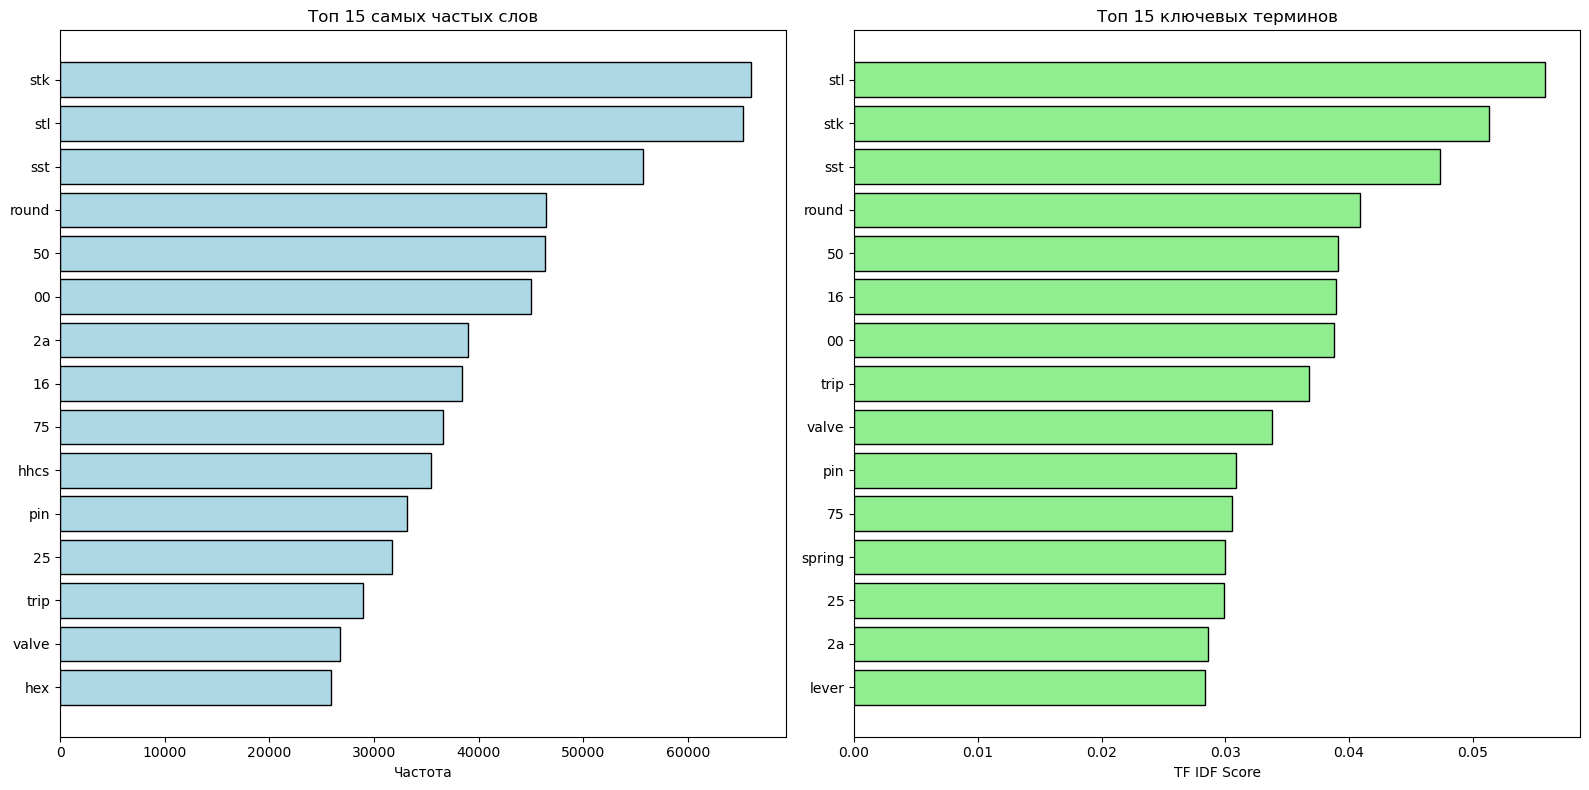


Топ 10 биграмм:


,bigram,count
15,round stk,46441
16,shroud band,18429
13,nut hex,17541
14,pipe plug,16644
18,sq hd,13442
6,band stk,10977
2,2a 00,9711
5,2b gr8,9506
3,2a 25,9027
4,2a 75,9026


In [21]:
# Частотный анализ слов
print("\033[1;36m" + "ЧАСТОТНЫЙ АНАЛИЗ СЛОВ" + "\033[0m")
print("-" * 60)

try:
    nltk.data.find('corpora/stopwords')
except:
    nltk.download('stopwords', quiet=True)
stop_words = set(nltk.corpus.stopwords.words('english'))

technical_stopwords = {
    'assy', 'assembly', 'part', 'component', 'kit', 'set', 'unit',
    'item', 'piece', 'material', 'product', 'device', 'element'
}
stop_words.update(technical_stopwords)

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

cleaned_descriptions = valid_descriptions.apply(preprocess_text)

print("Топ 10 самых частых слов:")
vectorizer = CountVectorizer(stop_words=list(stop_words), max_features=50)
X = vectorizer.fit_transform(cleaned_descriptions)
word_counts = np.array(X.sum(axis=0)).flatten()
words = vectorizer.get_feature_names_out()

word_freq_df = pd.DataFrame({
    'word': words,
    'count': word_counts,
    'frequency': word_counts / word_counts.sum() * 100
}).sort_values('count', ascending=False)

display(word_freq_df.head(10))

print("\nТоп 10 ключевых терминов по TF IDF:")
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stop_words), max_features=50)
tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_descriptions)
tfidf_scores = np.array(tfidf_matrix.mean(axis=0)).flatten()
tfidf_words = tfidf_vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame({
    'word': tfidf_words,
    'tfidf_score': tfidf_scores
}).sort_values('tfidf_score', ascending=False)

display(tfidf_df.head(10))

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

top_words = word_freq_df.head(15)
axes[0].barh(range(len(top_words)), top_words['count'], color='lightblue', edgecolor='black')
axes[0].set_yticks(range(len(top_words)))
axes[0].set_yticklabels(top_words['word'])
axes[0].set_xlabel('Частота')
axes[0].set_title('Топ 15 самых частых слов')
axes[0].invert_yaxis()

top_tfidf = tfidf_df.head(15)
axes[1].barh(range(len(top_tfidf)), top_tfidf['tfidf_score'], color='lightgreen', edgecolor='black')
axes[1].set_yticks(range(len(top_tfidf)))
axes[1].set_yticklabels(top_tfidf['word'])
axes[1].set_xlabel('TF IDF Score')
axes[1].set_title('Топ 15 ключевых терминов')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\nТоп 10 биграмм:")
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=list(stop_words), max_features=20)
bigrams = bigram_vectorizer.fit_transform(cleaned_descriptions)
bigram_counts = np.array(bigrams.sum(axis=0)).flatten()
bigram_words = bigram_vectorizer.get_feature_names_out()

bigram_df = pd.DataFrame({
    'bigram': bigram_words,
    'count': bigram_counts
}).sort_values('count', ascending=False)

display(bigram_df.head(10))

В топе слов - артикулы (stk, stl), размеры (50, 16) и классы прочности (2a). Чаще всего встречаются сочетания "round stk" (круглый сток) и "shroud band" (стяжная лента). Самые важные для этого набора термины - stl, stk, round, valve, pin.

### Графовый анализ

ГРАФОВЫЙ АНАЛИЗ СВЯЗЕЙ
------------------------------------------------------------
Размер графа:
  Узлов: 15,751
  Ребер: 649,253

СТЕПЕНИ УЗЛОВ
----------------------------------------
Изолированных узлов: 0 (0.0%)
Узлов со связями: 15751

Топ сборок по количеству компонентов:
  01H6394: 472 компонентов - Assembly 01H6394...
  00H6053: 459 компонентов - Assembly 00H6053...
  01T6497: 459 компонентов - Assembly 01T6497...
  01T6498: 459 компонентов - Assembly 01T6498...
  03T6871: 456 компонентов - Assembly 03T6871...

Топ компонентов по использованию:
  4H1618103: используется в 1,796 сборках - SCR DR TYPE U 2 X .25...
  401720107: используется в 1,791 сборках - RETAINING RING TRUARC N5000-125...
  8R1700005: используется в 1,785 сборках - ROUND STK 0.562/0.561 CG  SST...
  8R1700052: используется в 1,784 сборках - ROUND STK 1.312 SST...
  4H1626104: используется в 1,782 сборках - WASH LOC SPG 3/8...

КОМПОНЕНТЫ СВЯЗНОСТИ
----------------------------------------
Всего компонент связн

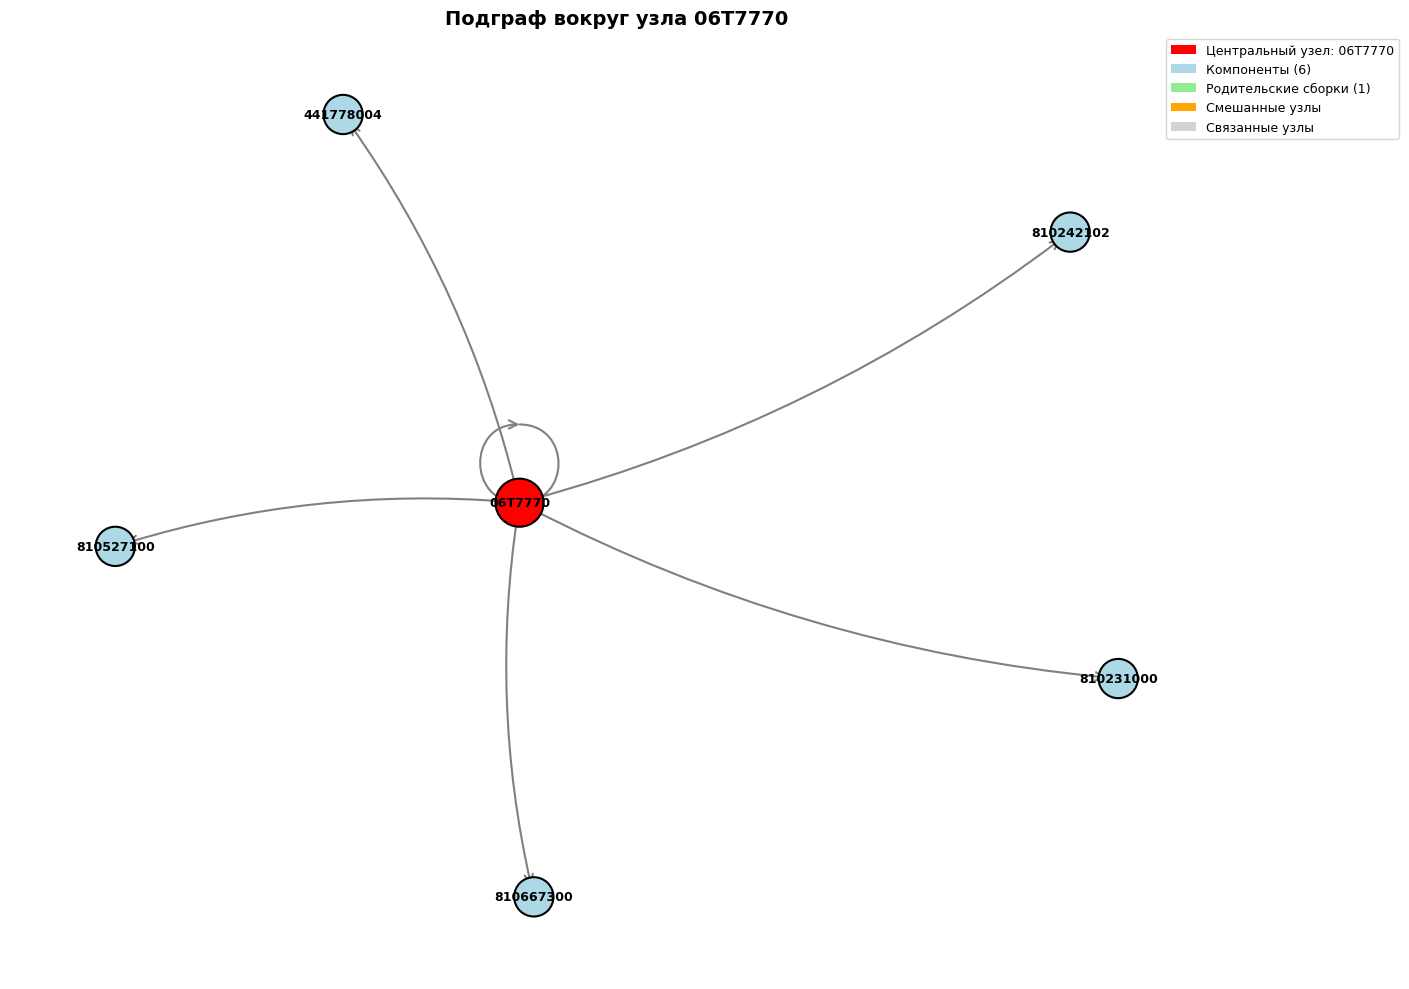

In [22]:
# Графовый анализ связей
print("\033[1;36m" + "ГРАФОВЫЙ АНАЛИЗ СВЯЗЕЙ" + "\033[0m")
print("-" * 60)

start_time = time.time()

# Создание графа из всех данных
G = nx.DiGraph()
edges_count = 0

for _, row in df.iterrows():
    if pd.notna(row['material_id']) and pd.notna(row['component_id']):
        G.add_edge(row['material_id'], row['component_id'], weight=row['qty'])
        edges_count += 1

print(f"Размер графа:")
print(f"  Узлов: {G.number_of_nodes():,}")
print(f"  Ребер: {edges_count:,}")

# Быстрый анализ степеней узлов
print("\n" + "\033[1;35m" + "СТЕПЕНИ УЗЛОВ" + "\033[0m")
print("-" * 40)

in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Определяем изолированные узлы (без анализа)
isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0]
print(f"Изолированных узлов: {len(isolated_nodes)} ({len(isolated_nodes)/G.number_of_nodes()*100:.1f}%)")

# Узлы с связями для анализа
connected_nodes = [node for node in G.nodes() if G.degree(node) > 0]
print(f"Узлов со связями: {len(connected_nodes)}")

# Анализ только связанных узлов
if connected_nodes:
    # Топ сборок по количеству компонентов
    print("\nТоп сборок по количеству компонентов:")
    top_out = sorted([(node, out_degrees[node]) for node in connected_nodes if out_degrees[node] > 0], 
                     key=lambda x: x[1], reverse=True)[:5]
    
    for node_id, degree in top_out:
        desc_rows = df[df['material_id'] == node_id]
        desc = desc_rows['description'].iloc[0] if len(desc_rows) > 0 else "N/A"
        print(f"  {node_id}: {degree:,} компонентов - {desc[:50]}...")
    
    # Топ компонентов по использованию
    print("\nТоп компонентов по использованию:")
    top_in = sorted([(node, in_degrees[node]) for node in connected_nodes if in_degrees[node] > 0], 
                    key=lambda x: x[1], reverse=True)[:5]
    
    for node_id, degree in top_in:
        desc_rows = df[df['component_id'] == node_id]
        desc = desc_rows['description'].iloc[0] if len(desc_rows) > 0 else "N/A"
        print(f"  {node_id}: используется в {degree:,} сборках - {desc[:50]}...")

# Анализ компонент связности (без удаления узлов)
print("\n" + "\033[1;35m" + "КОМПОНЕНТЫ СВЯЗНОСТИ" + "\033[0m")
print("-" * 40)

G_undirected = G.to_undirected()
connected_components = list(nx.connected_components(G_undirected))

print(f"Всего компонент связности: {len(connected_components)}")

if connected_components:
    # Сортируем по размеру
    sorted_components = sorted(connected_components, key=len, reverse=True)
    
    print(f"Размеры топ-3 компонент:")
    for i, comp in enumerate(sorted_components[:3]):
        print(f"  Компонент {i+1}: {len(comp):,} узлов ({len(comp)/G.number_of_nodes()*100:.1f}%)")
    
    # Анализ самой большой компоненты
    largest_component = sorted_components[0]
    if len(largest_component) > 1:
        G_largest = G_undirected.subgraph(largest_component)
        
        # Быстрая оценка метрик для большой компоненты
        print(f"\nАнализ наибольшей компоненты ({len(largest_component):,} узлов):")
        
        if len(largest_component) <= 5000:  # Разумный предел для расчетов
            try:
                # Приближенный диаметр
                sample_nodes = list(largest_component)[:min(100, len(largest_component))]
                max_distance = 0
                
                for node in sample_nodes[:10]:
                    try:
                        distances = nx.single_source_shortest_path_length(G_largest, node, cutoff=10)
                        if distances:
                            local_max = max(distances.values())
                            max_distance = max(max_distance, local_max)
                    except:
                        continue
                
                print(f"  Примерный диаметр: {max_distance}")
            except:
                print("  Диаметр: слишком большой для расчета")
        else:
            print("  Компонента слишком большая для детального анализа")

# Проверка циклических зависимостей (быстрая проверка)
print("\n" + "\033[1;35m" + "ЦИКЛИЧЕСКИЕ ЗАВИСИМОСТИ" + "\033[0m")
print("-" * 40)

try:
    # Быстрая проверка без полного поиска циклов
    if nx.is_directed_acyclic_graph(G):
        print("Граф ациклический")
    else:
        print("Граф содержит циклы")
        
        # Ищем короткие циклы в подграфе для примера
        if len(connected_nodes) > 0:
            # Берем подграф из топ узлов для поиска циклов
            sample_size = min(100, len(connected_nodes))
            sample_nodes = list(connected_nodes)[:sample_size]
            G_sample = G.subgraph(sample_nodes)
            
            try:
                cycles = list(nx.simple_cycles(G_sample))
                if cycles:
                    print(f"  Найдено циклов в выборке: {len(cycles)}")
                    for i, cycle in enumerate(cycles[:2]):
                        if len(cycle) <= 5:
                            print(f"    Цикл {i+1}: {' -> '.join(cycle)}")
            except:
                print("  Поиск циклов в выборке не удался")
except Exception as e:
    print(f"Ошибка проверки ацикличности: {e}")

# Статистика графа
print("\n" + "\033[1;35m" + "СТАТИСТИКА ГРАФА" + "\033[0m")
print("-" * 40)

if G.number_of_edges() > 0:
    density = G.number_of_edges() / (G.number_of_nodes() * (G.number_of_nodes() - 1))
    print(f"Плотность графа: {density:.6f}")
    
    avg_degree = 2 * G.number_of_edges() / G.number_of_nodes()
    print(f"Средняя степень узла: {avg_degree:.2f}")

# Анализ типов узлов
print("\n" + "\033[1;35m" + "ТИПЫ УЗЛОВ" + "\033[0m")
print("-" * 40)

assembly_count = sum(1 for node in G.nodes() if G.out_degree(node) > 0)
part_count = sum(1 for node in G.nodes() if G.in_degree(node) > 0 and G.out_degree(node) == 0)
leaf_count = sum(1 for node in G.nodes() if G.out_degree(node) == 0)

print(f"Сборки (имеют компоненты): {assembly_count:,}")
print(f"Детали (конечные компоненты): {part_count:,}")

# Визуализация подграфа
print("\n" + "\033[1;35m" + "ВИЗУАЛИЗАЦИЯ ПОДГРАФА" + "\033[0m")
print("-" * 40)

if len(connected_nodes) > 0:
    try:
        # Выбираем узел для визуализации (не корневой и с разумным количеством связей)
        non_root_nodes = [node for node in connected_nodes if G.out_degree(node) > 0]
        
        if not non_root_nodes:
            non_root_nodes = connected_nodes
            
        # Выбираем узел с умеренным количеством связей для лучшей визуализации
        candidate_nodes = [(node, out_degrees[node]) for node in non_root_nodes 
                          if 3 <= out_degrees[node] <= 15]
        
        if candidate_nodes:
            candidate_nodes.sort(key=lambda x: x[1])
            sample_node = candidate_nodes[len(candidate_nodes)//2][0]  # Медианный по сложности
        elif top_out:
            sample_node = top_out[0][0]
        else:
            sample_node = connected_nodes[0]
        
        print(f"Выбран узел для визуализации: {sample_node}")
        print(f"  - Компонентов (детей): {G.out_degree(sample_node)}")
        print(f"  - Родительских сборок: {G.in_degree(sample_node)}")
        
        # Получаем непосредственных детей и родителей
        direct_children = list(G.successors(sample_node))
        direct_parents = list(G.predecessors(sample_node))
        
        # Ограничиваем для читаемости
        max_children = min(6, len(direct_children))
        max_parents = min(4, len(direct_parents))
        
        children = direct_children[:max_children]
        parents = direct_parents[:max_parents]
        
        # Создаем базовый набор узлов
        nodes_to_include = {sample_node}
        nodes_to_include.update(children)
        nodes_to_include.update(parents)
        
        # Добавляем некоторые связи между непосредственными узлами
        additional_nodes = set()
        for node in children + parents:
            # Проверяем связи между детьми и родителями центрального узла
            for other_node in children + parents:
                if node != other_node:
                    # Если есть прямая связь между ними
                    if G.has_edge(node, other_node) or G.has_edge(other_node, node):
                        additional_nodes.add(node)
                        additional_nodes.add(other_node)
        
        # Добавляем обнаруженные связанные узлы
        nodes_to_include.update(additional_nodes)
        
        # Создаем подграф
        subgraph = G.subgraph(nodes_to_include)
        
        if subgraph.number_of_nodes() > 1:
            print(f"Создан подграф с {subgraph.number_of_nodes()} узлами и {subgraph.number_of_edges()} связями")
            
            plt.figure(figsize=(14, 10))
            
            # Используем spring layout для лучшего распределения
            pos = nx.spring_layout(subgraph, seed=42, k=1.5, iterations=100)
            
            # Определяем цвета узлов
            node_colors = []
            node_sizes = []
            
            for node in subgraph.nodes():
                if node == sample_node:
                    node_colors.append('red')
                    node_sizes.append(1200)
                elif node in children and node not in parents:
                    node_colors.append('lightblue')
                    node_sizes.append(800)
                elif node in parents and node not in children:
                    node_colors.append('lightgreen')
                    node_sizes.append(800)
                elif node in children and node in parents:
                    node_colors.append('orange')  # Одновременно и ребенок, и родитель
                    node_sizes.append(900)
                else:
                    node_colors.append('lightgray')
                    node_sizes.append(600)
            
            # Рисуем граф поэтапно для лучшего контроля
            nx.draw_networkx_nodes(subgraph, pos,
                                 node_color=node_colors,
                                 node_size=node_sizes,
                                 edgecolors='black',
                                 linewidths=1.5)
            
            # Рисуем ребра
            nx.draw_networkx_edges(subgraph, pos,
                                 edge_color='gray',
                                 arrows=True,
                                 arrowstyle='->',
                                 arrowsize=15,
                                 width=1.5,
                                 connectionstyle="arc3,rad=0.1")
            
            # Подписи узлов
            nx.draw_networkx_labels(subgraph, pos, 
                                  {node: node for node in subgraph.nodes()},
                                  font_size=9, 
                                  font_weight='bold')
            
            # Легенда
            legend_elements = [
                Patch(facecolor='red', label=f'Центральный узел: {sample_node}'),
                Patch(facecolor='lightblue', label=f'Компоненты ({len(children)})'),
                Patch(facecolor='lightgreen', label=f'Родительские сборки ({len(parents)})'),
                Patch(facecolor='orange', label='Смешанные узлы'),
                Patch(facecolor='lightgray', label='Связанные узлы')
            ]
            
            plt.legend(handles=legend_elements, loc='upper right', 
                      fontsize=9, bbox_to_anchor=(1.15, 1))
            
            plt.title(f'Подграф вокруг узла {sample_node}', fontsize=14, fontweight='bold')
            plt.axis('off')
            plt.tight_layout()
            plt.show()
            
        else:
            print("Не удалось создать подграф для визуализации")
            
    except Exception as e:
        print(f"Ошибка визуализации: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Нет связанных узлов для визуализации")

- Заметна высокая стандартизация в производстве. Топовые детали (4H1618103, 401720107) используются почти в 1,800 сборках
- Шраф полносвязный, все узлы образуют единую компоненту
- Циклических связей в графе нет (00H6016 - корень)


РАСПРЕДЕЛЕНИЕ ПО УРОВНЯМ ИЕРАРХИИ
------------------------------------------------------------
Статистика по уровням иерархии:


,level,count,percent,avg_qty,min_qty,max_qty,unique_materials,unique_components,avg_desc_length
0,0,61673,9.499070,1.590139,0.100,527.00,1884,9629,28.197688
1,1,337048,51.913199,2.972380,0.030,3600.00,1836,5289,24.451597
2,2,170338,26.235997,6.263004,0.030,510.00,1815,2505,24.085865
3,3,65556,10.097142,8.641176,0.020,204.00,1807,895,26.073128
4,4,13223,2.036648,1.933431,0.030,50.00,1779,408,29.087589
5,5,594,0.091490,3.472795,0.690,164.00,186,268,27.274874
6,6,525,0.080862,2.032857,0.500,41.00,9,381,26.800403
7,7,212,0.032653,6.628538,1.000,231.00,6,179,23.671498
8,8,75,0.011552,17.688467,0.135,463.00,3,60,29.178082
9,9,9,0.001386,25.892222,1.000,213.03,2,8,29.555556


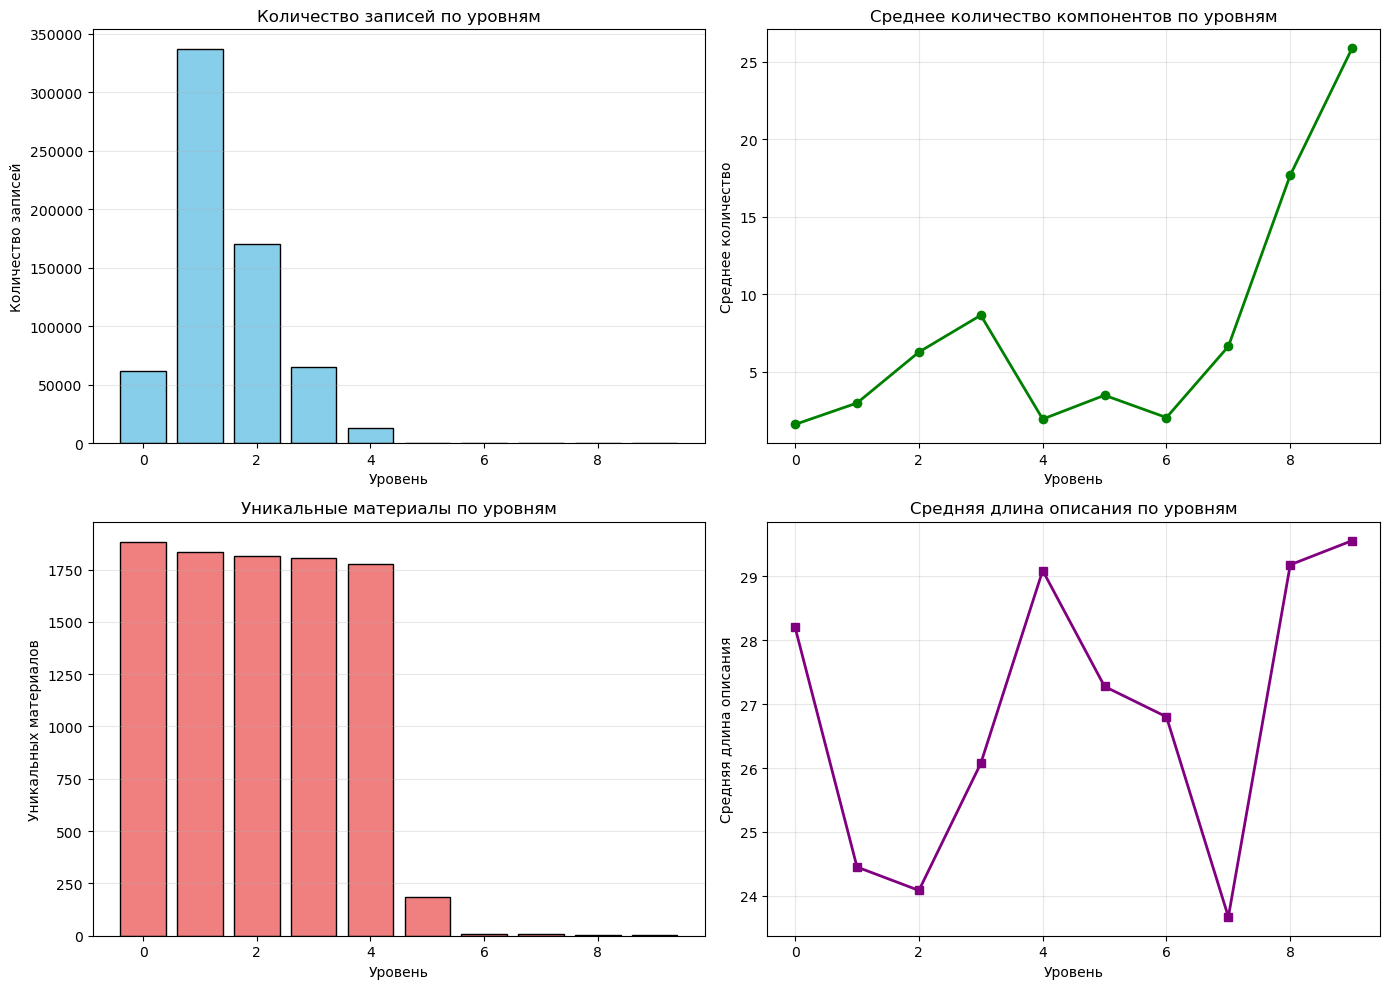


АНАЛИЗ КОРНЕВЫХ УЗЛОВ
----------------------------------------
Всего корневых узлов: 1884

Топ 10 корневых узлов по количеству компонентов:
  98H4275: 274 компонентов - Assembly 98H4275...
  98H4270: 272 компонентов - Assembly 98H4270...
  98H4274: 271 компонентов - Assembly 98H4274...
  98H4272: 226 компонентов - Assembly 98H4272...
  98H4332: 213 компонентов - Assembly 98H4332...
  98H4276: 213 компонентов - Assembly 98H4276...
  98H4317: 211 компонентов - Assembly 98H4317...
  98H4331: 209 компонентов - Assembly 98H4331...
  98T4318: 187 компонентов - Assembly 98T4318...
  98H4391: 186 компонентов - Assembly 98H4391...

АНАЛИЗ КОМПОНЕНТОВ ЛИСТЬЕВ
----------------------------------------
Всего компонентов листьев: 13867

Распределение листьев по уровням:
  Уровень 0: 59789 листьев (9.2%)
  Уровень 1: 337048 листьев (52.1%)
  Уровень 2: 170338 листьев (26.3%)
  Уровень 3: 65556 листьев (10.1%)
  Уровень 4: 13223 листьев (2.0%)
  Уровень 5: 594 листьев (0.1%)
  Уровень 6: 525 листьев 

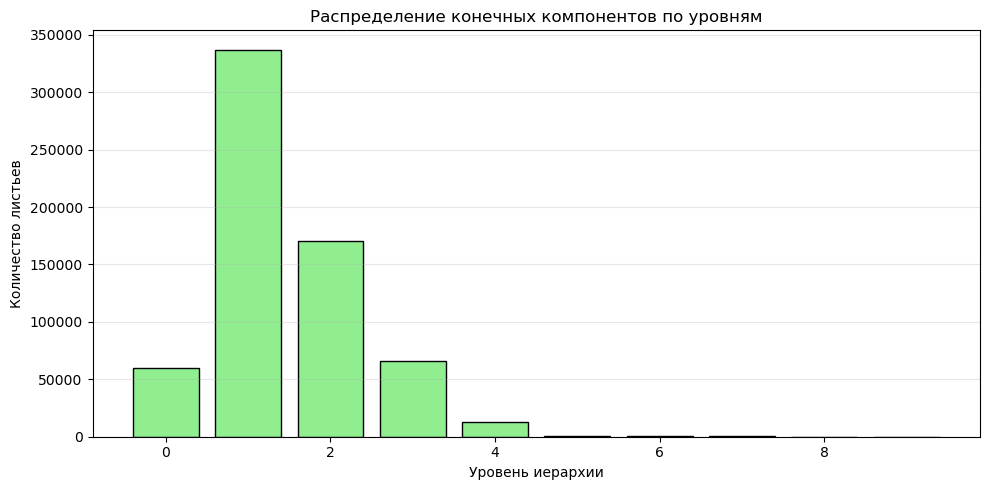

In [23]:
# Анализ распределения по уровням иерархии
print("\033[1;36m" + "РАСПРЕДЕЛЕНИЕ ПО УРОВНЯМ ИЕРАРХИИ" + "\033[0m")
print("-" * 60)

level_analysis = []

for level in range(0, df['level'].max() + 1):
    level_data = df[df['level'] == level]
    
    if len(level_data) > 0:
        level_stats = {
            'level': level,
            'count': len(level_data),
            'percent': len(level_data) / len(df) * 100,
            'avg_qty': level_data['qty'].mean(),
            'min_qty': level_data['qty'].min(),
            'max_qty': level_data['qty'].max(),
            'unique_materials': level_data['material_id'].nunique(),
            'unique_components': level_data['component_id'].nunique(),
            'avg_desc_length': level_data['description'].str.len().mean() if 'description' in level_data.columns else 0
        }
        level_analysis.append(level_stats)

level_df = pd.DataFrame(level_analysis)

print("Статистика по уровням иерархии:")
display(level_df)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].bar(level_df['level'], level_df['count'], color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Уровень')
axes[0, 0].set_ylabel('Количество записей')
axes[0, 0].set_title('Количество записей по уровням')
axes[0, 0].grid(axis='y', alpha=0.3)

axes[0, 1].plot(level_df['level'], level_df['avg_qty'], marker='o', color='green', linewidth=2)
axes[0, 1].set_xlabel('Уровень')
axes[0, 1].set_ylabel('Среднее количество')
axes[0, 1].set_title('Среднее количество компонентов по уровням')
axes[0, 1].grid(alpha=0.3)

axes[1, 0].bar(level_df['level'], level_df['unique_materials'], color='lightcoral', edgecolor='black')
axes[1, 0].set_xlabel('Уровень')
axes[1, 0].set_ylabel('Уникальных материалов')
axes[1, 0].set_title('Уникальные материалы по уровням')
axes[1, 0].grid(axis='y', alpha=0.3)

if 'avg_desc_length' in level_df.columns:
    axes[1, 1].plot(level_df['level'], level_df['avg_desc_length'], marker='s', color='purple', linewidth=2)
    axes[1, 1].set_xlabel('Уровень')
    axes[1, 1].set_ylabel('Средняя длина описания')
    axes[1, 1].set_title('Средняя длина описания по уровням')
    axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "\033[1;35m" + "АНАЛИЗ КОРНЕВЫХ УЗЛОВ" + "\033[0m")
print("-" * 40)

root_nodes = df[df['level'] == 0]
print(f"Всего корневых узлов: {len(root_nodes['material_id'].unique())}")

root_components = root_nodes.groupby('material_id').agg({
    'component_id': 'count',
    'description': 'first'
}).sort_values('component_id', ascending=False).head(10)

print("\nТоп 10 корневых узлов по количеству компонентов:")
for idx, row in root_components.iterrows():
    print(f"  {idx}: {row['component_id']} компонентов - {row['description'][:60]}...")

print("\n" + "\033[1;35m" + "АНАЛИЗ КОМПОНЕНТОВ ЛИСТЬЕВ" + "\033[0m")
print("-" * 40)

all_materials = set(df['material_id'].unique())
all_components = set(df['component_id'].unique())

leaf_components = all_components - all_materials
print(f"Всего компонентов листьев: {len(leaf_components)}")

leaf_data = df[df['component_id'].isin(leaf_components)]
leaf_level_dist = leaf_data['level'].value_counts().sort_index()

print("\nРаспределение листьев по уровням:")
for level, count in leaf_level_dist.items():
    print(f"  Уровень {level}: {count} листьев ({count/len(leaf_data)*100:.1f}%)")

plt.figure(figsize=(10, 5))
plt.bar(leaf_level_dist.index, leaf_level_dist.values, color='lightgreen', edgecolor='black')
plt.xlabel('Уровень иерархии')
plt.ylabel('Количество листьев')
plt.title('Распределение конечных компонентов по уровням')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Структура похожа на пирамиду - первый уровень самый большой (52% всех деталей), дальше уровни становятся меньше.** Самые глубокие уровни (6-9) содержат всего 0.1% деталей. Корневые сборки сложные содержат по 200-270 компонентов каждая. Основные детали находятся близко к верху иерархии, а не на глубине. 

**Наблюдается закономерность в количестве компонентов**: среднее количество компонентов на сборку увеличивается с глубиной от 1.6 на уровне 0 до 25.9 на уровне 9, что показывает рост сложности сборок на нижних уровнях иерархии. 


## Общий вывод

Данные представляют собой иерархическую спецификацию сборок машиностроительного производства. Они содержат минимальное количество пропусков, отсутствуют критические ошибки в виде отрицательных количеств или полных дубликатов. Структура данных образует связный граф с глубиной до девяти уровней, где закономерные дубликаты отражают реальное многократное использование компонентов. 

Основные обнаруженные проблемы включают несоответствие длины пути между уровнями вложенности, наличие специальных символов в идентификаторах и пропущенные описания у ряда стандартных деталей.

План дальнейшей обработки начинается с исправления структурных проблем. Это включает стандартизацию идентификаторов компонентов путём замены недопустимых символов, очистку текстовых описаний от служебных комментариев и корректировку иерархических полей для создания единого представления об уровнях вложенности. 

Следующим этапом станет обогащение данных и извлечение признаков. Из текстовых описаний будут извлечены структурированные атрибуты, такие как материал, тип компонента, размеры. На основе графа связей рассчитаны метрики, характеризующие популярность и критичность каждого компонента в общей структуре. Также будут агрегированы количественные показатели использования деталей.